# **Forecasting Realized Volatility**

In contrast to *implied volatility* (IV), which reflects the market’s expectation of future uncertainty, *realized volatility* (RV) corresponds to the volatility that actually materializes over a given horizon. From a modeling perspective, RV exhibits strong persistence and clustering, making it more forecastable than IV or returns themselves.

## Why Forecast Realized Volatility?

Forecasting RV is valuable for several reasons in both trading and risk management:

- **Volatility Trading & IV–RV Strategies**  
  Accurate RV forecasts allow us to identify mispricings between implied and realized volatility.  
  For example, if IV is significantly higher than the forecasted RV, it may indicate an opportunity to short volatility and harvest the volatility risk premium (VRP).

- **Position Sizing**  
  Forecasted volatility can be used to dynamically scale positions: larger sizes in calm regimes, smaller sizes in volatile markets.  
  This volatility targeting improves risk-adjusted returns.

- **Risk Management (Stop Loss / Take Profit)**  
  RV forecasts help set realistic expectations for daily or monthly moves, which can inform stop-loss and take-profit levels in directional strategies.

---

By systematically modeling and forecasting RV — using approaches such as HAR models, GARCH-type processes, or machine learning — we can generate signals that are not only academically robust but also directly actionable in trading strategies.


The notebook is structured as follows:

1. [Read & Prepare Data](#read_data)
2. [Volatility Estimators](#real-vol)
   - [2.1. Historical (close-to-close): 10D, 21D, 100D](#trade-execution-setup)
   - [2.2. Range-based (OHLC): Parkinson, GK, Rogers-Satchel, Yang Zhang](#trade-execution-setup)
   - [2.3. High-Frequency Estimators: Realized Variance](#e)
3. [Stylized facts of realized volatility](#real-vol)
4. [Problem Formualation]()
   - [5.1 Target Variable: 21-Day Realized Variance](#trade-execution-setup)
   - [5.1 Predictors of realized volatility](#trade-execution-setup)
5. [Feature Engineering](#real-vol)
6. [Data-Preprocessing](#real-vol)
7. [Feature Selection](#real-vol)
8. [Forecasting Models](#real-vol)
9. [Evaluation: Walk forward with cross val, RMSE vs QLIKE, plotting residuals, refitting models every months](#real-vol)

In [1473]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

from dotenv import load_dotenv
from matplotlib import gridspec
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, BaseCrossValidator
from sklearn.linear_model import LassoCV
from sklearn.inspection import permutation_importance
from scipy.stats import skew, kurtosis

import utility.plot_helpers as ph
from src.iv_surface.ssvi_model import SSVI
from utility.greeks import solve_strike_for_delta

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

pd.options.mode.chained_assignment = None 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **1. Read & Prepare Data**

For this analysis we are going to consider daily S&P500 OHLC data from Yahoo finance from `2018` to `2025` and prepare it for analysis.

In [2]:
start = "2010-01-01"
end = "2020-12-31"

spx = yf.download("^GSPC", start=start, end=end, auto_adjust=True)
spx.columns = spx.columns.droplevel("Ticker")
spx.columns.name = None
spx

[*********************100%***********************]  1 of 1 completed


Close         High          Low         Open      Volume
Date                                                                      
2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059  3991400000
2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034  2491020000
2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961  4972660000
2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020  5270680000
2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020  4389590000
...                 ...          ...          ...          ...         ...
2020-12-23  3690.010010  3711.239990  3689.280029  3693.419922  3779160000
2020-12-24  3703.060059  3703.820068  3689.320068  3694.030029  1883780000
2020-12-28  3735.360107  3740.510010  3723.030029  3723.030029  3535460000
2020-12-29  3727.040039  3756.120117  3723.310059  3750.010010  3393290000
2020-12-30  3732.040039  3744.629883  3730.209961  3736.189941  3154850000

[2768 rows x 5 columns]

In [3]:
spx.isna().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [4]:
spx["returns"] = np.log(spx["Close"] / spx["Close"].shift(1))
spx = spx.dropna()
spx

Close         High          Low         Open      Volume  \
Date                                                                         
2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034  2491020000   
2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961  4972660000   
2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020  5270680000   
2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020  4389590000   
2010-01-11  1146.979980  1149.739990  1142.020020  1145.959961  4255780000   
...                 ...          ...          ...          ...         ...   
2020-12-23  3690.010010  3711.239990  3689.280029  3693.419922  3779160000   
2020-12-24  3703.060059  3703.820068  3689.320068  3694.030029  1883780000   
2020-12-28  3735.360107  3740.510010  3723.030029  3723.030029  3535460000   
2020-12-29  3727.040039  3756.120117  3723.310059  3750.010010  3393290000   
2020-12-30  3732.040039  3744.629883  3730.209961  3736.189941  3154850000   

             returns  
Date                  
2010-01-05  0.003111  
2010-01-06  0.000545  
2010-01-07  0.003993  
2010-01-08  0.002878  
2010-01-11  0.001745  
...              ...  
2020-12-23  0.000746  
2020-12-24  0.003530  
2020-12-28  0.008685  
2020-12-29 -0.002230  
2020-12-30  0.001341  

[2767 rows x 6 columns]

Text(0.5, 1.0, 'Log Returns')

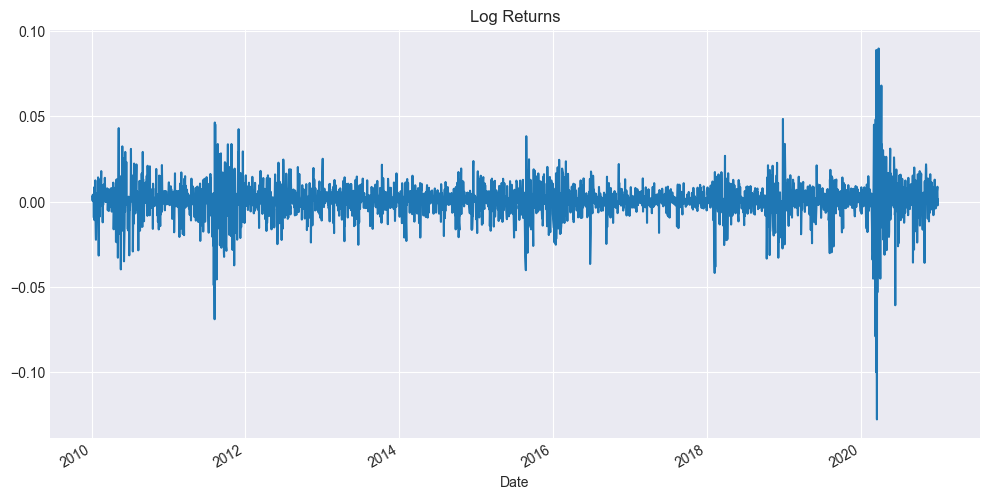

In [5]:
spx["returns"].plot(figsize=(12, 6))
plt.title("Log Returns")

# **2. Volatility Estimators**

Volatility is a *latent* quantity — it cannot be observed directly. To evaluate forecasts and build predictors, we need to construct **proxies** from price data. Different estimators trade off bias vs efficiency depending on the sampling frequency and data available.

## 2.1 Historical / Close-to-Close

The simplest approach uses only closing price data and is often called the **close-to-close estimator**.   It computes realized volatility from consecutive daily returns. This estimator serves as a useful **benchmark**, but it suffers from several drawbacks: it ignores intraday variation, overnight jumps, and the information contained in opening, high, and low prices, which often makes it downward biased.

Formally, over a horizon $H$:

$$
RV_{t,H} = \sqrt{\tfrac{252}{H} \sum_{j=1}^H r_{t+j}^2}, 
\quad r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

In [6]:
def rv_close_to_close(returns, h=21, ann=252):
    var = returns.pow(2).rolling(h).sum() * (ann / h)
    return np.sqrt(var)

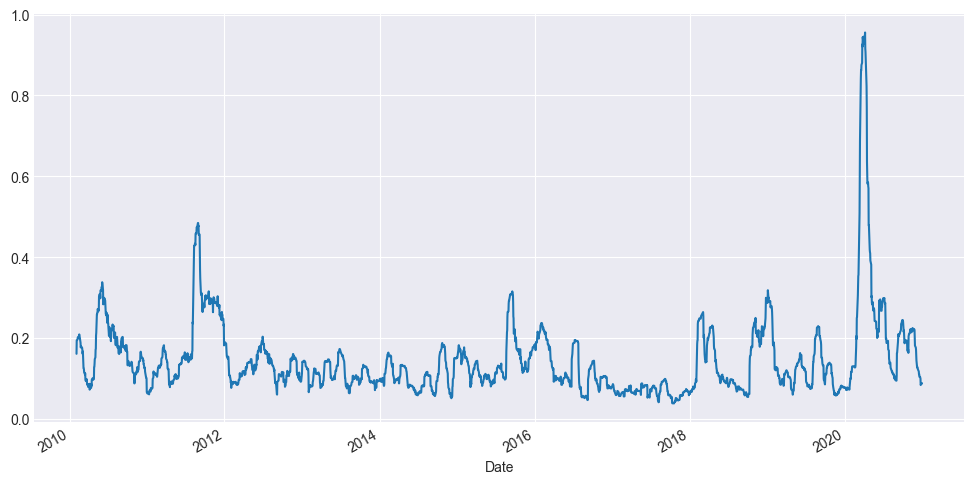

In [7]:
spx["rv_close"] = rv_close_to_close(spx["returns"], h=21)
spx["rv_close"].plot(figsize=(12, 6))
plt.show()

## 2.2 Range-Based Proxies (OHLC)

Instead of relying only on closing prices, we can extract more information from each trading day by incorporating the **Open, High, Low, and Close (OHLC)** prices.  
Over the years, several range-based estimators have been proposed, each addressing specific shortcomings of the close-to-close method and earlier estimators.  
These approaches typically reduce variance in the volatility estimate and account for intraday dynamics, but each comes with its own assumptions and limitations.

### 2.2.1 Parkinson Estimator

The **Parkinson (1980) estimator** uses the daily high–low range to capture intraday price variability.  
By relying on the full range rather than just closing prices, it provides a more efficient estimate of volatility under the assumption of a **driftless geometric Brownian motion**.  

However, it ignores opening and closing prices and is highly sensitive to jumps or bid–ask bounce at the extremes of the trading day.

Formally, over a horizon $H$:

$$
RV^{\text{Parkinson}}_{t,H} 
= \sqrt{ \frac{252}{4H \ln(2)} \sum_{j=1}^H \left[ \ln\!\left(\tfrac{H_{t+j}}{L_{t+j}}\right) \right]^2 }
$$

In [8]:
def rv_parkinson(high, low, h=21, ann=252):
    rp = np.log(high / low).pow(2)  # per-day range variance proxy
    var = rp.rolling(h, min_periods=h).sum() * (ann / (4 * np.log(2) * h))
    return np.sqrt(var)

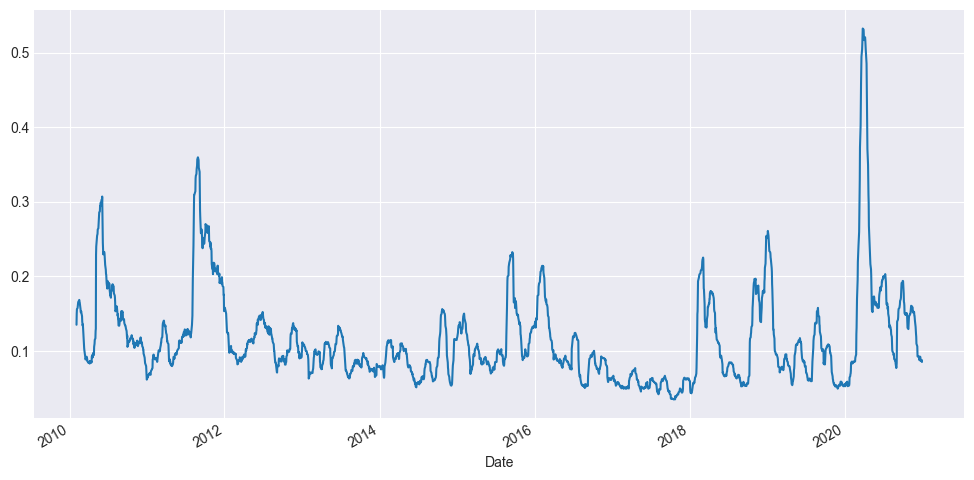

In [9]:
spx["rv_parkinson"] = rv_parkinson(spx["High"], spx["Low"], h=21)
spx["rv_parkinson"].plot(figsize=(12, 6))
plt.show()

### 2.2.2 Garman–Klass Estimator

The **Garman–Klass (1980) estimator** improves upon the Parkinson measure by incorporating not only the daily high and low, but also the open and close prices.  
This allows it to capture more information about intraday price variation and reduce estimation variance under the assumption of a driftless geometric Brownian motion.  

However, like the Parkinson estimator, it can be biased in the presence of significant drift or opening jumps, since it assumes zero drift and continuous trading.

Formally, over a horizon $H$:

$$
RV^{\text{GK}}_{t,H} 
= \sqrt{ \frac{252}{H} \sum_{j=1}^H 
\left[ \tfrac{1}{2} \left( \ln\!\left(\tfrac{H_{t+j}}{L_{t+j}}\right) \right)^2 
- (2\ln(2) - 1) \left( \ln\!\left(\tfrac{C_{t+j}}{O_{t+j}}\right) \right)^2 
\right] }
$$

In [10]:
def rv_garman_klass(open_, high, low, close, h=21, ann=252):
    # Daily GK variance (no drift)
    rs = 0.5 * (np.log(high/low).pow(2)) - (2*np.log(2) - 1) * (np.log(close/open_).pow(2))
    var = rs.rolling(h).sum() * (ann / h)
    return np.sqrt(var)

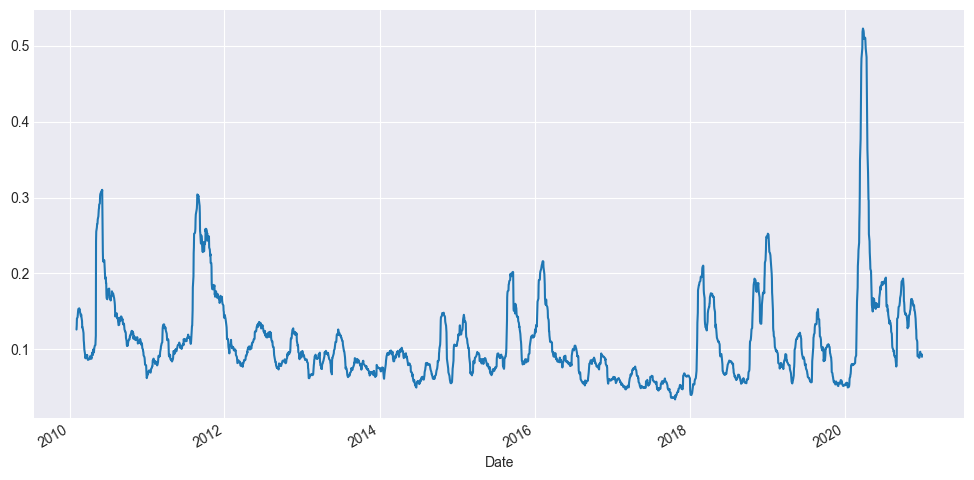

In [11]:
spx["rv_gk"] = rv_garman_klass(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_gk"].plot(figsize=(12, 6))
plt.show()

### 2.2.3 Rogers–Satchell Estimator

The **Rogers–Satchell (1991) estimator** was introduced to overcome one of the limitations of the Parkinson and Garman–Klass estimators: their assumption of zero drift.  
The Rogers–Satchell measure is **drift-robust**, making it better suited for assets that experience trending behavior.  
It uses all four OHLC prices, but in a different functional form that explicitly accommodates nonzero expected returns.  

While it handles drift effectively, it remains sensitive to microstructure noise and extreme jumps at the open or close.

Formally, over a horizon $H$:

$$
RV^{\text{RS}}_{t,H} 
= \sqrt{ \frac{252}{H} \sum_{j=1}^H 
\left[ 
\ln\!\left(\tfrac{H_{t+j}}{C_{t+j}}\right) \cdot \ln\!\left(\tfrac{H_{t+j}}{O_{t+j}}\right) 
+ \ln\!\left(\tfrac{L_{t+j}}{C_{t+j}}\right) \cdot \ln\!\left(\tfrac{L_{t+j}}{O_{t+j}}\right) 
\right] }
$$

In [12]:
def rv_rogers_satchell(open_, high, low, close, h=21, ann=252):
    term1 = np.log(high/close) * np.log(high/open_)
    term2 = np.log(low/close) * np.log(low/open_)
    rs = (term1 + term2)
    var = rs.rolling(h).sum() * (ann/h)
    return np.sqrt(var)

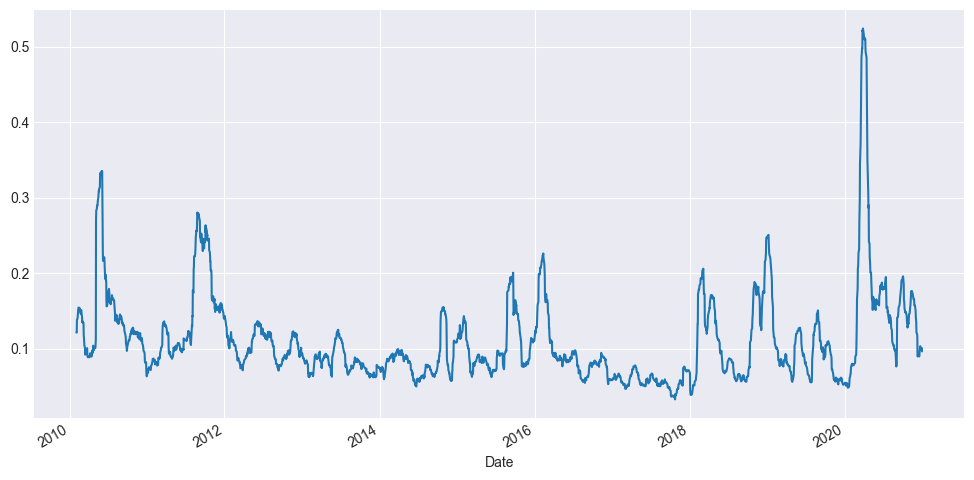

In [13]:
spx["rv_rs"] = rv_rogers_satchell(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_rs"].plot(figsize=(12, 6))
plt.show()

### 2.2.4 Yang–Zhang Estimator

The **Yang–Zhang (2000) estimator** combines the advantages of previous methods by incorporating overnight variance, open-to-close variance, and the Rogers–Satchell range-based component.  
It is **unbiased in the presence of drift**, less sensitive to opening jumps, and has significantly lower estimation variance compared to Parkinson, Garman–Klass, or Rogers–Satchell taken alone.  

This makes Yang–Zhang one of the most efficient daily volatility estimators available when OHLC data are present.

Formally, the daily Yang–Zhang variance can be expressed as:

$$
\sigma^2_{YZ} = \sigma^2_O + k \, \sigma^2_C + (1-k)\, \sigma^2_{RS}
$$

where  
- $\sigma^2_O = \big( \ln(O_t / C_{t-1}) \big)^2$ is the overnight variance,  
- $\sigma^2_C = \big( \ln(C_t / O_t) \big)^2$ is the open-to-close variance,  
- $\sigma^2_{RS}$ is the Rogers–Satchell variance component,  
- $k \approx 0.34$ is a weight chosen to minimize bias and variance.  

Aggregating over a horizon $H$:

$$
RV^{\text{YZ}}_{t,H} = \sqrt{ \frac{252}{H} \sum_{j=1}^H \sigma^2_{YZ,\,t+j} }
$$

In [14]:
def rv_yang_zhang(open_, high, low, close, h=21, ann=252, k=0.34):
    # Overnight return variance
    oc = np.log(open_/close.shift(1))
    sigma_o = oc.pow(2)

    # Open-to-close variance
    co = np.log(close/open_)
    sigma_c = co.pow(2)

    # Rogers–Satchell component
    rs = (
        np.log(high/close) * np.log(high/open_) +
        np.log(low/close) * np.log(low/open_)
    )

    # Daily YZ variance
    yz = sigma_o + k*sigma_c + (1-k)*rs

    var = yz.rolling(h, min_periods=h).sum() * (ann/h)
    return np.sqrt(var)

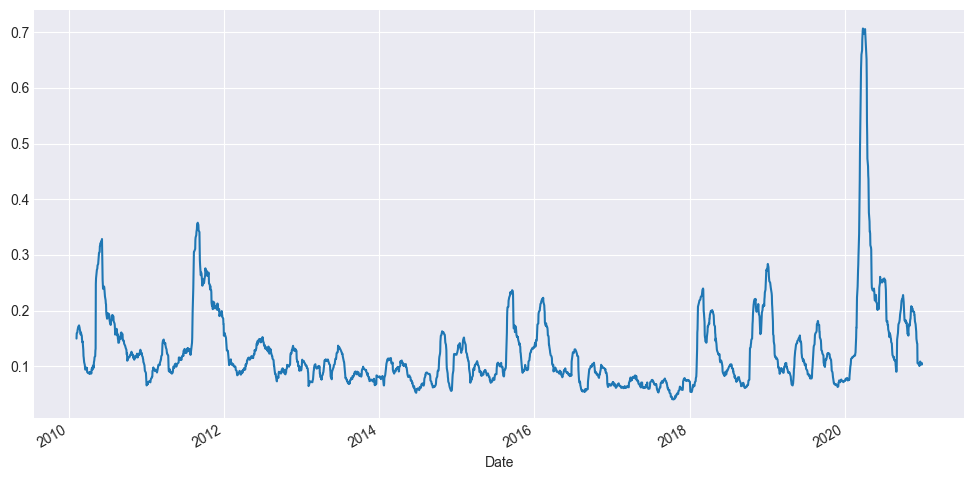

In [15]:
spx["rv_yz"] = rv_yang_zhang(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_yz"].plot(figsize=(12, 6))
plt.show()

## 2.3 Which Estimator to choose ?

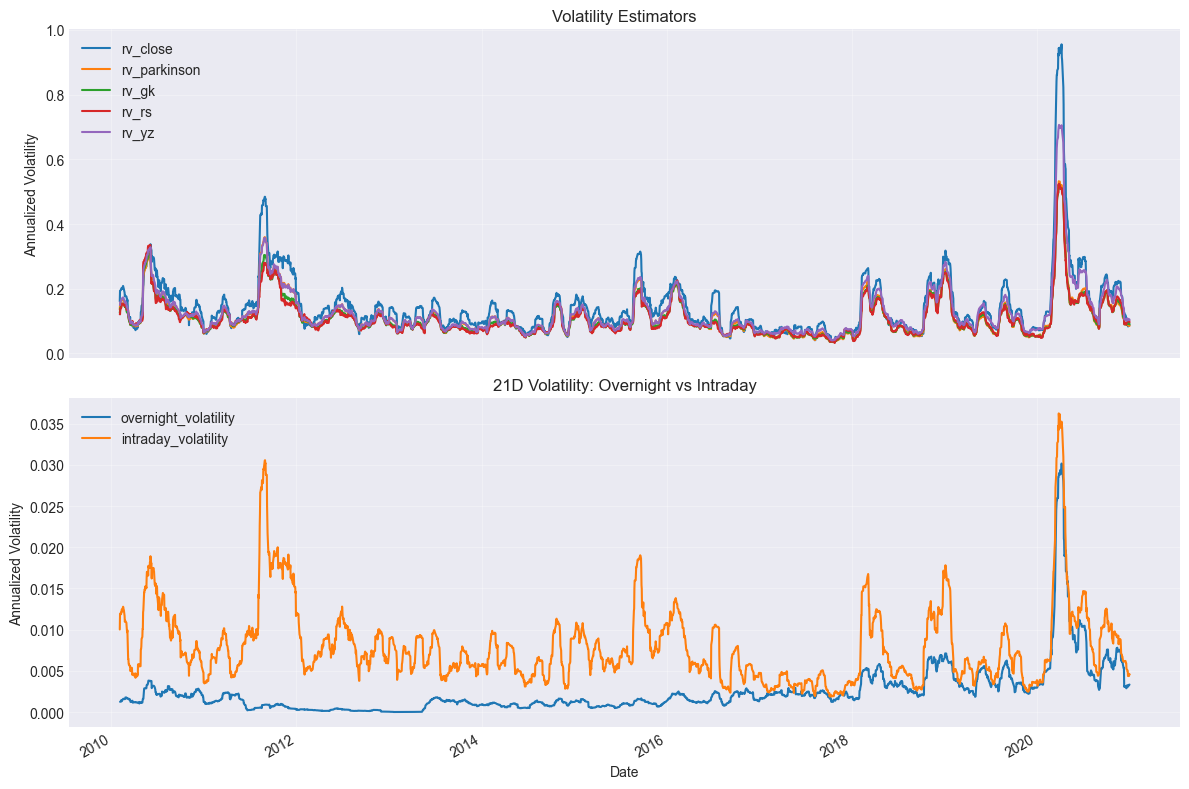

In [16]:
spx["overnight_volatility"] = np.log(spx["Open"] / spx["Close"].shift(1)).rolling(21).std()
spx["intraday_volatility"] = np.log(spx["Close"] / spx["Open"]).rolling(21).std()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- top panel: volatility estimators ---
spx.loc[:, spx.columns.str.startswith("rv")].plot(ax=ax1)
ax1.set_title("Volatility Estimators")
ax1.set_ylabel("Annualized Volatility")
ax1.grid(alpha=0.3)
ax1.legend()

# --- bottom panel: overnight vs intraday volatility ---
spx[["overnight_volatility", "intraday_volatility"]].plot(ax=ax2)
ax2.set_title("21D Volatility: Overnight vs Intraday")
ax2.set_ylabel("Annualized Volatility")
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

- **Insight:** You’ll see that in stress regimes (e.g., 2008, COVID-19 crash), *overnight moves dominate*. YZ explicitly accounts for this.

### 2.3 High-Frequency Estimators: Realized Variance

With **5-minute high-frequency data**, we can incorporate much more intraday information than when relying only on daily OHLC data.  
In this notebook, we use **E-mini S&P 500 futures (ES)**, which trade almost 24 hours a day, so the realized measure naturally includes overnight returns as well.  

The choice of a 5-minute sampling grid is widely recognized as the best trade-off between capturing information and avoiding microstructure distortions: it explains about **90–95% of daily integrated variance**. At higher frequencies (e.g., 1-min, tick), **microstructure noise**—such as bid–ask bounce and discrete price jumps—becomes more prominent, requiring more advanced techniques (e.g., **pre-averaged RV** or **realized kernels**).  

As a baseline, we consider the **realized variance (RV)** estimator, defined over a day $t$ with intraday returns $r_{t,i}$ as:

$$
RV_t = \sum_{i=1}^{N_t} r_{t,i}^2,
\quad 
r_{t,i} = \ln\!\left(\frac{P_{t,i}}{P_{t,i-1}}\right)
$$

where $N_t$ is the number of 5-minute intervals within day $t$, and $P_{t,i}$ denotes the price at interval $i$.

In [17]:
es_5min = pd.read_csv("data/intermediate/es-5m.csv", 
                 sep=";", 
                 header=None,
                 names=["date","time","open","high","low","close","volume"])

es_5min["datetime"] = pd.to_datetime(es_5min["date"] + " " + es_5min["time"], 
                                     format="%d/%m/%Y %H:%M:%S")

es_5min = es_5min.drop(columns=["date","time"]).set_index("datetime").sort_index()

es_5min = es_5min.loc[start:end]
es_5min

open     high      low    close  volume
datetime                                                       
2010-01-03 17:00:00  1113.75  1115.25  1113.25  1114.25    4700
2010-01-03 17:05:00  1114.25  1115.50  1114.25  1114.75    1804
2010-01-03 17:10:00  1114.50  1115.25  1114.50  1115.00     785
2010-01-03 17:15:00  1115.25  1116.00  1114.75  1115.75    1143
2010-01-03 17:20:00  1115.75  1116.25  1115.50  1116.00     643
...                      ...      ...      ...      ...     ...
2020-12-31 15:35:00  3746.75  3747.25  3746.00  3746.75     902
2020-12-31 15:40:00  3746.75  3747.25  3746.50  3747.00     582
2020-12-31 15:45:00  3747.00  3747.50  3745.75  3746.75     879
2020-12-31 15:50:00  3746.50  3748.25  3746.25  3748.00     615
2020-12-31 15:55:00  3748.00  3749.25  3747.50  3748.75    1335

[774160 rows x 5 columns]

In [18]:
es_5min.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [19]:
es_5min[es_5min.index.duplicated(keep=False)]

Empty DataFrame
Columns: [open, high, low, close, volume]
Index: []

In [20]:
es_5min = es_5min[~es_5min.index.duplicated(keep="last")]

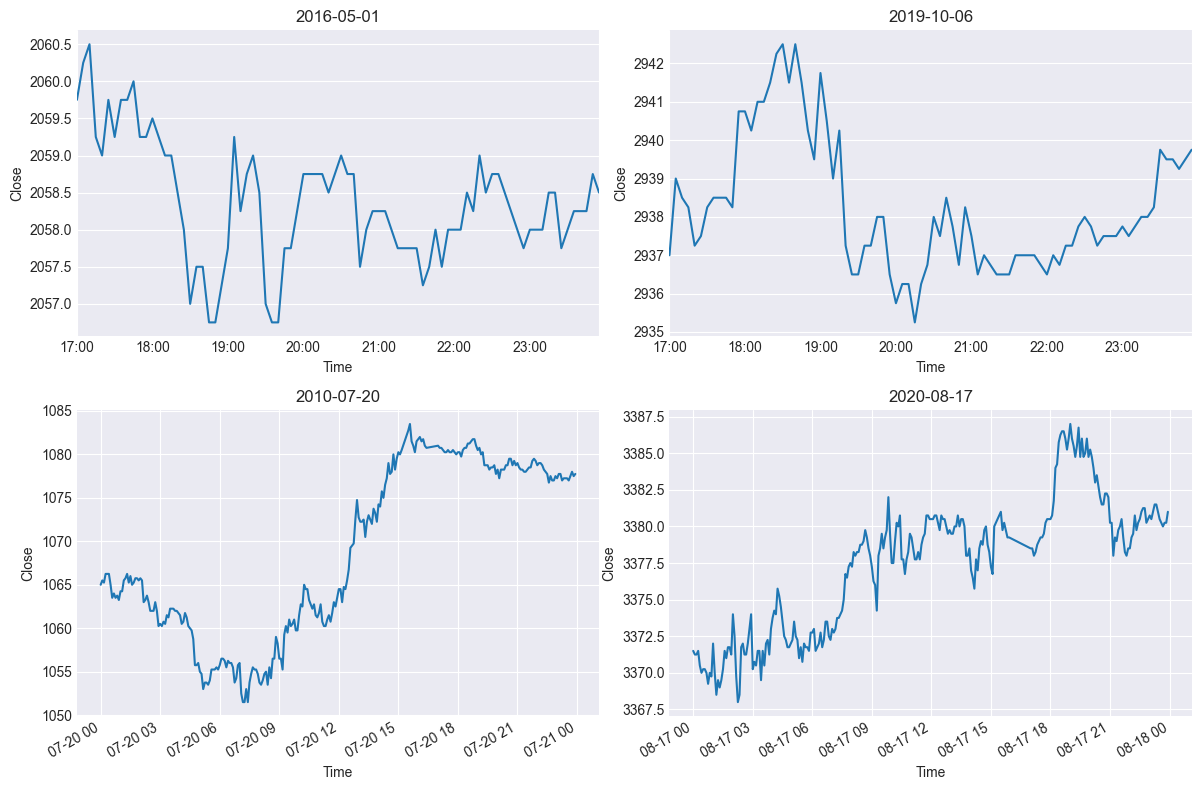

In [21]:
# pick 4 random days
all_days = es_5min.index.normalize().unique().date
days = np.random.choice(all_days, size=4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, day in zip(axes.ravel(), days):
    es_5min.loc[str(day), "close"].plot(ax=ax)
    ax.set_title(day.strftime("%Y-%m-%d"))
    ax.set_xlabel("Time")
    ax.set_ylabel("Close")

plt.tight_layout()
plt.show()

There are some interpolated prices, but oeverall teh quality looks good comapred to yfinance for isnatcne where msot of the series would be interpolated.

In [ ]:
def daily_realized_variance(close, rth_start: str = "09:30", rth_end: str = "16:00"):
    """
    Compute daily realized variance from intraday data:
        RV_t = sum_i r_{t,i}^2, where r_{t,i} = log(P_{t,i}/P_{t,i-1})
    """
    # intraday log returns
    tod = close.index.strftime("%H:%M")
    rth = close[(tod >= rth_start) & (tod <= rth_end)].copy()
    r = np.log(rth).diff()

    # sum of squared intraday returns by day
    rv_daily = r.pow(2).groupby(rth.index.date).sum()
    rv_daily.index = pd.to_datetime(rv_daily.index)
    rv_daily.name = "var_daily"

    return rv_daily

In [23]:
daily_rv = daily_realized_variance(es_5min["close"])
es_rv_21 = np.sqrt(daily_rv.rolling(21).mean() * 252)

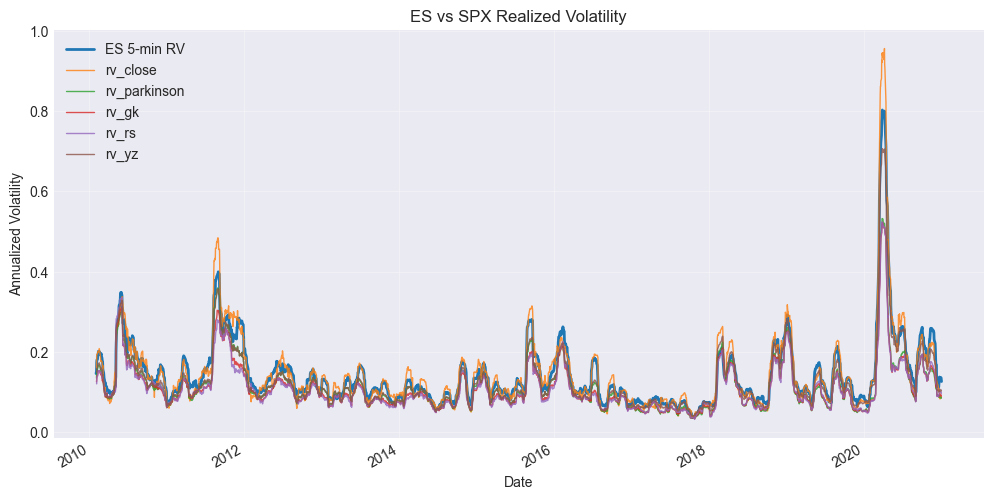

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

es_rv_21.plot(ax=ax, label="ES 5-min RV", lw=2)
spx.loc[:, spx.columns.str.startswith("rv")].plot(ax=ax, lw=1, alpha=0.8)

ax.set_title("ES vs SPX Realized Volatility")
ax.set_ylabel("Annualized Volatility")
ax.grid(alpha=0.3)
ax.legend()

plt.show()

The difference between close-to-close and realized variance is evne more pormiennt at daily frequency.

# **3. Stylized facts of daily volatility**

Here we will be investgating stylized facts of daily volatility that can be used for modelling perspective. The idea is to highlight the key charcetristics of daily varaicne that can be leveraged to forecast the future volaitltiy. From a modellign perspective it is betetr to work diertcly with varaicne instea dof std (isnce variance is additive) as well as dealing with the daily one isnetad of teh monthyl rollign one (which does not align with the stylized fatcs which come from daily frequency).

Volatility us 

- ACF-PACF of saurred returns (persistence)
- Volatiltiy clusterign & Mean reversion
- Leverage effect

## 3.1 Volatility clustering

It is the msot important phenomena as volatility is not constant, it evolves in low and high volatility regimes respecitvely. The idea is that high (resp. low) level of voalitlities tend to be follwoed by high (resp. low) level of volaitlity respectievly.

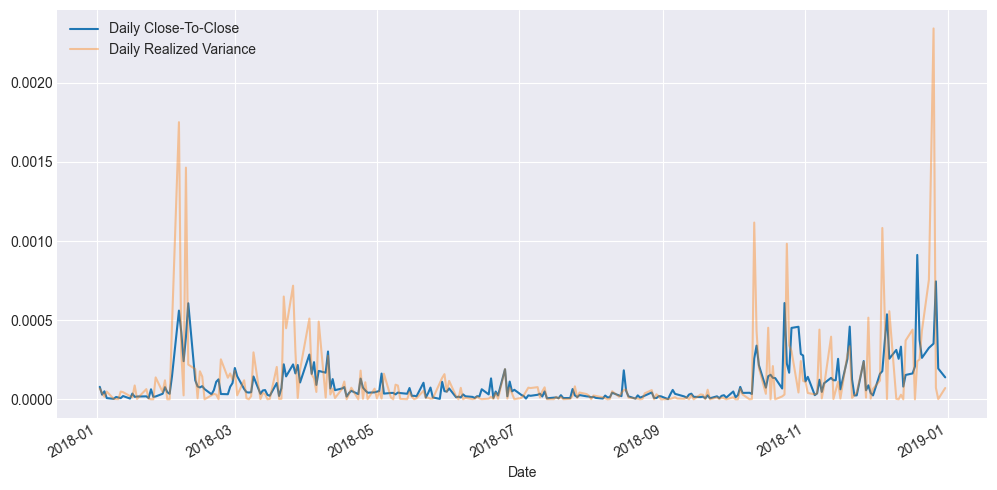

In [25]:
daily_c2c = spx["returns"].pow(2)

plt.figure(figsize=(12, 6))
daily_rv.loc["2018"].plot(alpha=1, label="Daily Close-To-Close")
daily_c2c.loc["2018"].plot(alpha=0.4, label="Daily Realized Variance")
plt.legend()
plt.show()

## 3.2 Long Memory / Slow Decay

Squarred retursn and realized varaicne show strong persiteenc eover many lags. Means today’s volatility has predictive power even months ahead. Thi smotivates the use of HAR-RV models that parsimuniusly include many lags until monthyl lags.

In [26]:
def plot_acf_pacf(series, lags=40, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))

    plot_acf(series.dropna(), lags=lags, ax=axes[0])
    axes[0].set_title(f"ACF {title}")

    plot_pacf(series.dropna(), lags=lags, ax=axes[1], method="ywm")  # Yule-Walker-M estimator
    axes[1].set_title(f"PACF {title}")

    plt.tight_layout()
    plt.show()

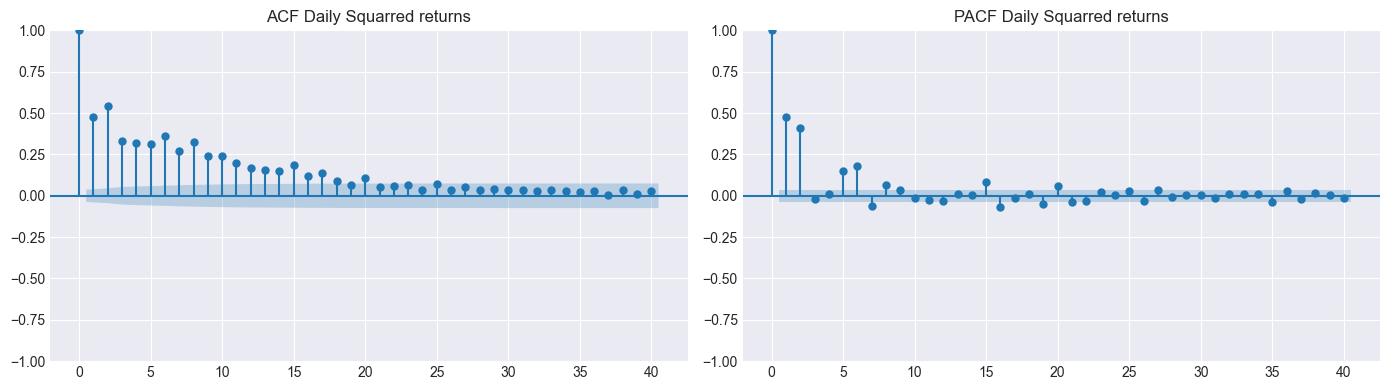

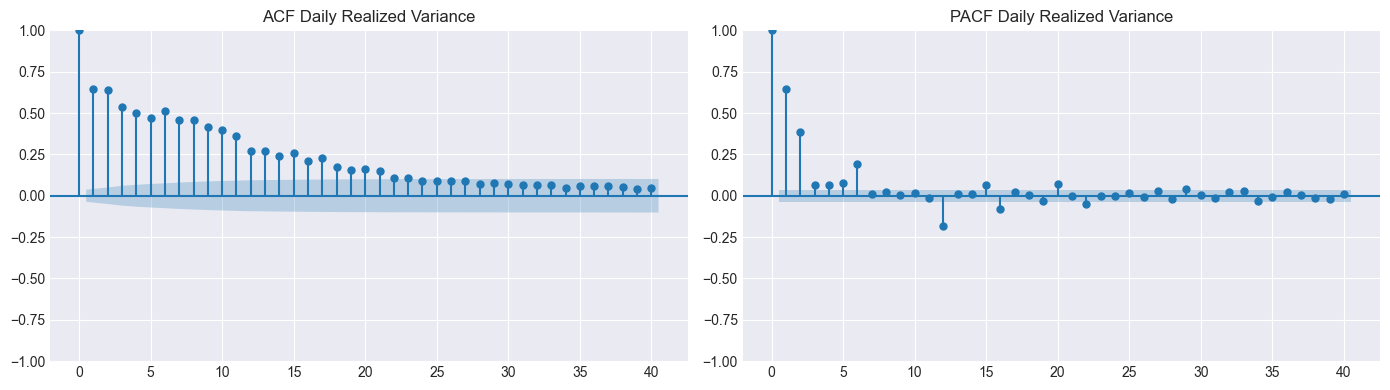

In [27]:
plot_acf_pacf(daily_c2c, lags=40, title="Daily Squarred returns")
plot_acf_pacf(daily_rv, lags=40, title="Daily Realized Variance")

For short horizons, the realized varaicne is more persitent than the close-to-close appromxiated by squarred returns with lags which ate meaningful until 1 months thus we could use autoregressive terms until the 21th to forecast teh next day volatility.

## 3.3 Mean-reverting behaviour

Volatility is mean revrting, namely after a shoch it tends to revrrt slowly towards its uncondtional long term mean.

In [28]:
from statsmodels.tsa.ar_model import AutoReg

# Fit AR(1) model
model = AutoReg(daily_rv.to_numpy(), lags=1, old_names=False)
res = model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 2835
Model:                     AutoReg(1)   Log Likelihood               19576.101
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Wed, 05 Nov 2025   AIC                         -39146.202
Time:                        09:21:00   BIC                         -39128.354
Sample:                             1   HQIC                        -39139.764
                                 2835                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.869e-05   4.81e-06      8.045      0.000    2.93e-05    4.81e-05
y.L1           0.6461      0.014     45.068      0.000       0.618       0.674
                                    Roots           

The regression coefficient sugguest that the variance has mean-reverting property that can be leveraged in autoregression mdoel like **GARCH**

## 3.4 Volatility distributions are often log-normal

Volatility is strictly positive, highly right-skewed, and empirically close to **log-normal**.  
In other words, while raw volatility (RV, IV) has a heavy-tailed distribution,  
its logarithm is much closer to Normal.

**Modeling benefits:**
- **Positivity:** By modeling log-volatility and exponentiating back, forecasts are guaranteed ≥ 0.  
- **Better fit:** Log-volatility is closer to Gaussian → forecast errors are more symmetric and homoscedastic.  
- **Statistical validity:** Standard linear models (ARMA, HAR-RV, regressions) work more reliably on log-volatility.  

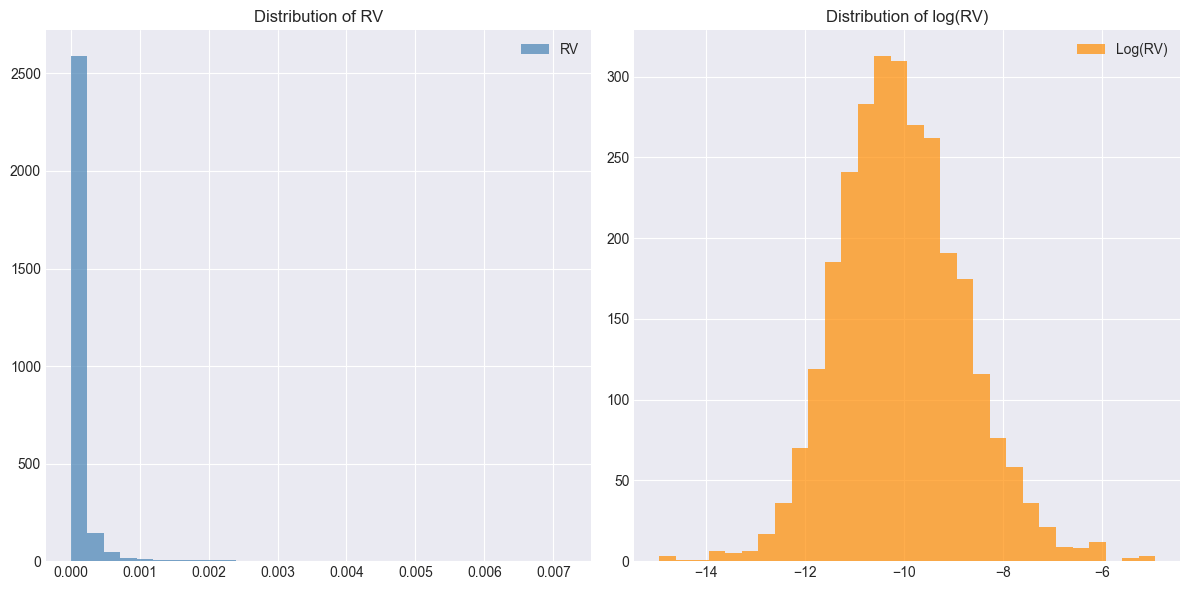

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

daily_rv.hist(bins=30, ax=axes[0], label="RV", color="steelblue", alpha=0.7)
axes[0].set_title("Distribution of RV")
axes[0].legend()

np.log(daily_rv).hist(bins=30, ax=axes[1], label="Log(RV)", color="darkorange", alpha=0.7)
axes[1].set_title("Distribution of log(RV)")
axes[1].legend()

plt.tight_layout()
plt.show()

## 3.5 Asymmetry / Leverage Effect

Another key stylized fact is the **asymmetric relation between returns and volatility**:  
- Negative returns (price drops) tend to increase future volatility more than positive returns of the same magnitude.  
- This is often called the **leverage effect**, since a fall in equity prices increases financial leverage, making the firm riskier.  
- In practice, this creates an asymmetric volatility–return correlation:
  - Correlation between returns and future volatility < 0.

**Modeling implications:**
- Symmetric models (e.g., standard GARCH) cannot capture this.  
- Asymmetric extensions such as EGARCH, GJR-GARCH, or stochastic volatility with leverage are used to account for it.  

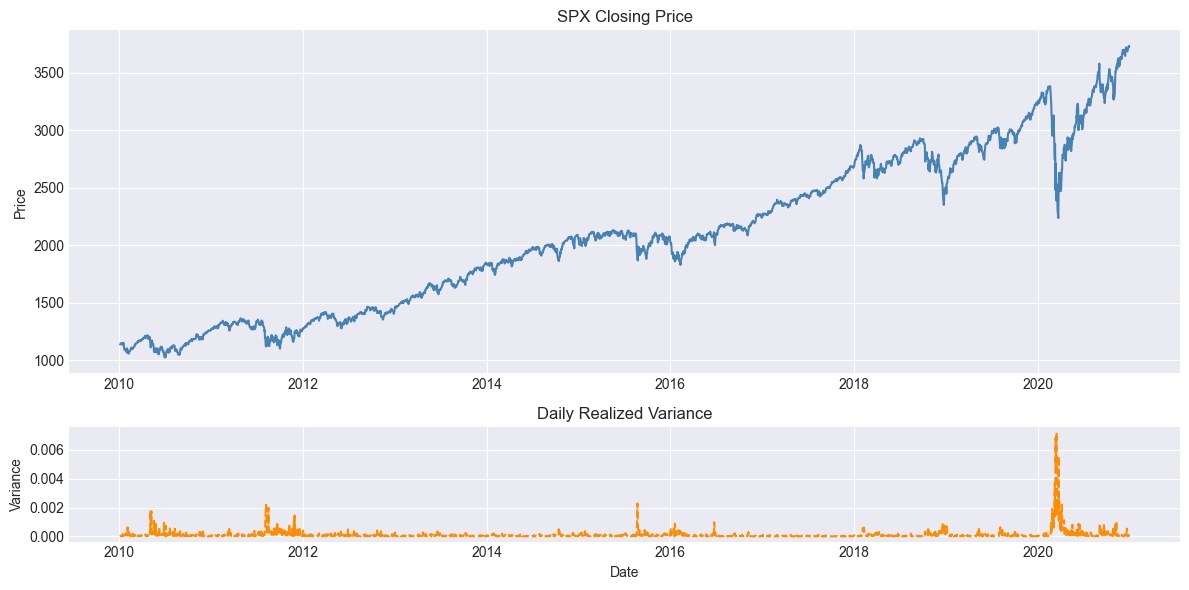

In [31]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # top 3x bigger than bottom

# Top: SPX closing price
ax1 = fig.add_subplot(gs[0])
ax1.plot(spx.index, spx["Close"], color="steelblue")
ax1.set_title("SPX Closing Price")
ax1.set_ylabel("Price")

# Bottom: realized volatility
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(daily_rv.index, daily_rv, color="darkorange", linestyle="--")
ax2.set_title("Daily Realized Variance")
ax2.set_ylabel("Variance")
ax2.set_xlabel("Date")

plt.tight_layout()
plt.show()

Here we can see that durign stress regimes voalitltiy tend to spike.

# **4. Problem Formulation**

We frame the task as a supervised learning problem: forecasting the 21-day forward realized volatility of the S&P 500.

Formally, the objective is to predict forward realized volatility using only information available at time $t$.  

$$
y_t = f(X_t; \beta) + \varepsilon_t, \quad \text{with } \mathbb{E}[y_t | X_t] = f(X_t; \beta)
$$

where:
- $y_t$ = target variable (forward 21-day realized volatility),
- $X_t$ = vector of predictors at time $t$.
- $f(.;\beta)$ = parametric or non-parametric form of the regressors


## 4.1 Target Variable: 21-Day Realized Variance

For forecasting purposes, it is convenient to define the target in terms of **daily realized volatility** averaged over the forward horizon.  
This follows the econometric convention (Christoffersen, Corsi, etc.), where multi–day realized volatility is expressed as the mean of daily RVs rather than as total variance.

Since realized variance and volatility are highly skewed and approximately log-normal, we work in the **logarithmic scale**:

$$
y_t = \log\!\big(RV_{t+1:t+21}\big)
$$

where the forward 21-day realized variance aligned at time $t$ is defined as:

$$
RV_{t+1:t+21} 
= \frac{RV_{t+1} + RV_{t+2} + \cdots + RV_{t+21}}{21}
$$

with $RV_{t+i}$ denoting the one-day realized volatility computed from intraday (5-min) returns.

- The **log transform** reduces skewness, stabilizes variance, and makes the distribution closer to Gaussian.  
- It also guarantees positivity when transformed back:

$$
\hat{RV}_{t+1:t+21} = \exp(\hat{y}_t).
$$

In [202]:
def create_forward_target(daily_variance: pd.Series, horizon: int = 21) -> pd.Series:
    """
    daily_variance: per-day realized variance (NOT sqrt, NOT annualized).
                    index = trading days.
    horizon: forecast horizon in trading days (e.g. 21 ~ 1 month).

    Returns:
        y_t = log( average future variance from t+1 to t+horizon )
    """
    # trailing mean, then realign to t as forward mean
    fwd_avg_var = (
        daily_variance
        .rolling(horizon).mean()       # at t+h: mean of [t+1 .. t+h]
        .shift(-horizon)               # move it back so it's aligned at t
    )

    y = np.log(fwd_avg_var)
    y.name = f"log_fwd_var_{horizon}d"
    return y

H = 21
y = create_forward_target(daily_rv, horizon=14)

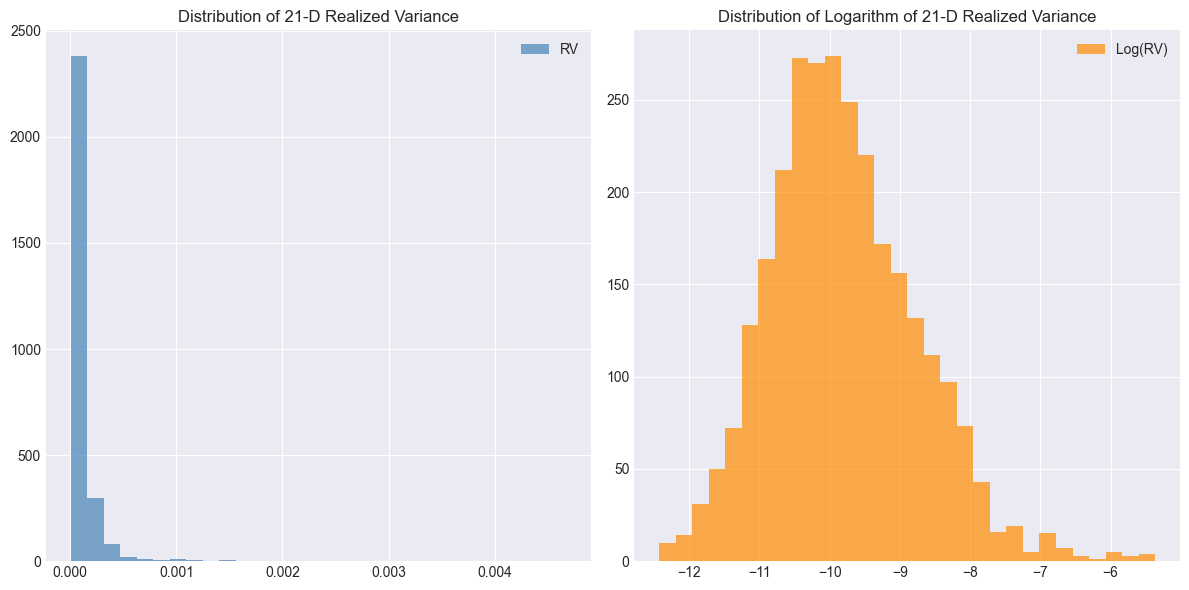

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

np.exp(y).hist(bins=30, ax=axes[0], label="RV", color="steelblue", alpha=0.7)
axes[0].set_title("Distribution of 21-D Realized Variance")
axes[0].legend()

y.hist(bins=30, ax=axes[1], label="Log(RV)", color="darkorange", alpha=0.7)
axes[1].set_title("Distribution of Logarithm of 21-D Realized Variance")
axes[1].legend()

plt.tight_layout()
plt.show()

## 4.2 Predictor Families

We use features observable at time (t), grouped into families where each fmailly covers one parituclar aspect of the foward RV.

### 4.2.1 Lagged Volatility Measures: HAR-RV Lags (1D, 5D, 22D)

As seen in the ACF plots, realized variance exhibits strong persistence, remaining significant up to at least 21 lags. This motivates the use of **lagged realized variance/volatility** as predictors.

A common specification is the **HAR-RV (Heterogeneous Autoregressive) structure**, which captures short, medium, and long-term memory effects by including daily, weekly, and monthly averages of past realized variance:

$$
X_{t}^{HAR} = RV_{D,t} + RV_{W,t} + RV_{M,t}
$$

where:
- $RV_{D,t} = RV_{t}$ (daily lag, short-term persistence)  
- $RV_{W,t} = \tfrac{1}{5}\sum_{i=0}^{4} RV_{t-i}$ (weekly average, medium-term)  
- $RV_{M,t} = \tfrac{1}{21}\sum_{i=0}^{20} RV_{t-i}$ (monthly average, long-term)  

This formulation smooths noisy daily lags and reflects the heterogeneous behavior of different market participants (daily traders, weekly rebalancers, monthly institutions).

In [113]:
def create_har_lags(real_variance):
    X_har = pd.DataFrame({
        "RV_D": real_variance,                   # yesterday’s daily RV
        "RV_W": real_variance.rolling(5).mean(), # weekly avg of daily RVs
        "RV_M": real_variance.rolling(21).mean() # monthly avg of daily RVs
    })
    return X_har

X_har = create_har_lags(daily_rv)

In [114]:
summary_stats = ['count','mean','std','min','max','skew','kurtosis']

X_har = create_har_lags(daily_rv)
X_har.agg(summary_stats)

RV_D         RV_W         RV_M
count     2.835000e+03  2831.000000  2815.000000
mean      1.092941e-04     0.000109     0.000110
std       3.170964e-04     0.000263     0.000219
min       3.257165e-07     0.000004     0.000006
max       7.191973e-03     0.004678     0.002556
skew      1.255384e+01    10.254128     7.915824
kurtosis  2.195748e+02   135.858842    74.452912

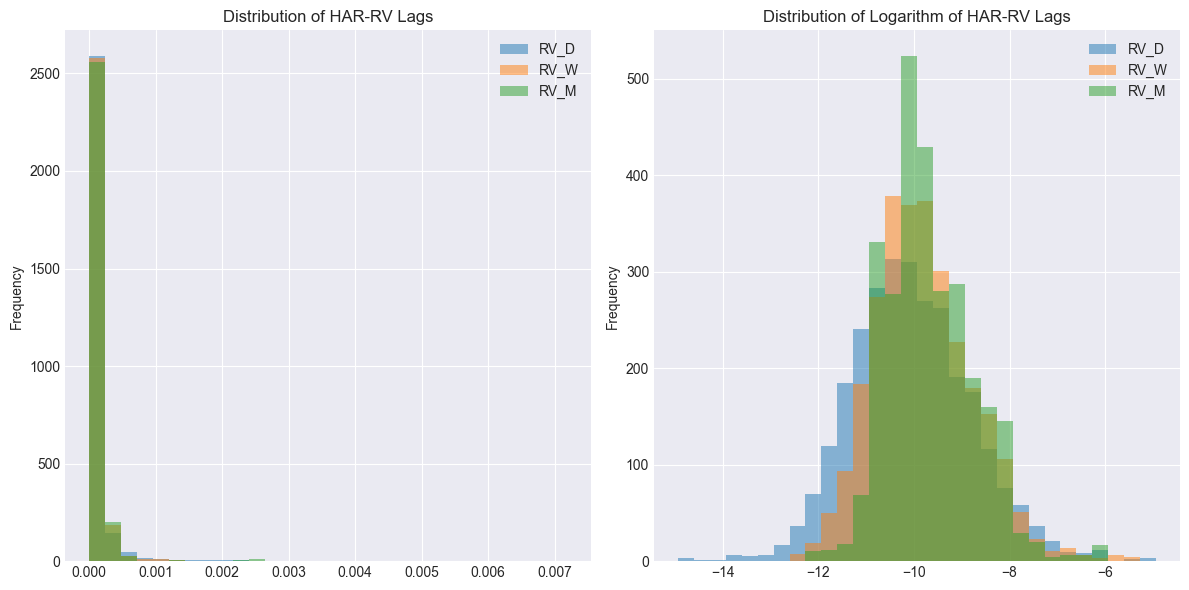

In [1143]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

X_har.plot.hist(bins=30, ax=axes[0], label="RV", alpha=0.5)
axes[0].set_title("Distribution of HAR-RV Lags")
axes[0].legend()

np.log(X_har).plot.hist(bins=30, ax=axes[1], label="Log(RV)", alpha=0.5)
axes[1].set_title("Distribution of Logarithm of HAR-RV Lags")
axes[1].legend()

plt.tight_layout()
plt.show()

#### **Transformation Decisions**
- Apply `log` transform to: `RV_D`, `RV_W`, `RV_M`.

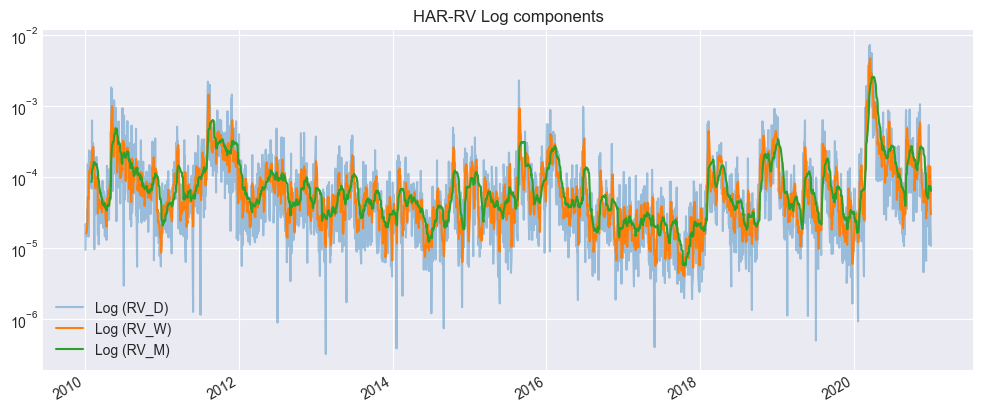

In [115]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.set_yscale("log")
X_har["RV_D"].plot(ax=ax, alpha=0.4, label="Log (RV_D)")
X_har["RV_W"].plot(ax=ax, alpha=1, label="Log (RV_W)")
X_har["RV_M"].plot(ax=ax, alpha=1, label="Log (RV_M)")
plt.legend(); plt.title("HAR-RV Log components")
plt.show()

In [116]:
def plot_features_vs_target(X, y, log_features=None, figsize=(12, 6), cmap="viridis", nrows=None, ncols=None):
    log_features = log_features or []

    if not ncols:
        n_cols = len(X.columns)
        ncols = 2

    if not nrows:
        nrows = (n_cols + 1) // 2

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for ax, col in zip(axes, X.columns):
        x = X[col].to_numpy()

        if col in log_features:
            x = np.log(x + 1e-8)  # small offset to avoid log(0)
            x_label = f"log({col})"
        else:
            x_label = col

        hb = ax.hexbin(x, y, gridsize=40, mincnt=1, cmap=cmap)
        ax.set_title(f"{x_label} vs log(y)")
        ax.set_xlabel(x_label)
        ax.set_ylabel("log(y)")
        fig.colorbar(hb, ax=ax, shrink=0.8)

    plt.tight_layout()
    plt.show()

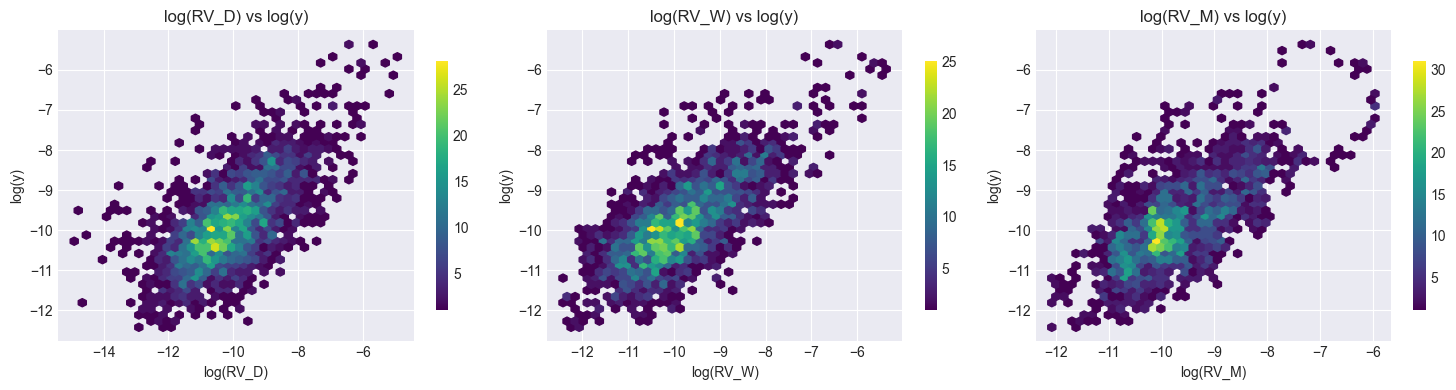

In [117]:
plot_features_vs_target(X_har, y, log_features=X_har.columns.tolist(), figsize=(15, 4), nrows=1, ncols=3)

### 4.2.2 Implied Volatility Signals  

While realized volatility lags capture **persistence**, implied volatility (IV) embeds the market’s **forward-looking expectations** of future volatility and risk premia.  
Here we focus on features derived from the option surface of the underlying we trade:

- **ATM IV (1M maturity)**  
  Near-the-money implied volatility for ~1-month options, closely linked to the traded option premium and less contaminated by skew than indices such as VIX.  

- **25Δ IV Skew (Risk Reversal)**  
  Difference between the 1M 25-delta OTM put IV and the 1M 25-delta OTM call IV.  
  This 25Δ risk-reversal skew serves as a proxy for the **downside risk premium** and crash-protection demand: steeper (more negative) skew typically corresponds to elevated tail-risk pricing.  

- **IV Term Structure**  
  Slope between short- and long-dated IVs (1M vs 3M).  
  An **inverted term structure** (front IV > back IV) typically signals near-term stress, whereas an upward-sloping structure is more consistent with benign or mean-reverting volatility regimes.  

These IV-based predictors complement RV lags by providing a **market-implied view of future volatility**, which is central for constructing IV–RV mispricing signals.

In [124]:
spx_options = pd.read_parquet("data/intermediate/full_spx_options_2010_2020.parquet")

spx_options["T"] = spx_options["dte"] / 252 # Time to expity in years
spx_options["k"] = np.log(
    spx_options["strike"] / spx_options["underlying_last"] # Log-forward moneyness
 )

In [ ]:
def create_iv_surface_predictors(options, iv_surface_model, params=None, r=0.0, q=0.0):
    iv_features = []
    T_30 = 30 / 252
    T_60 = 60 / 252

    for date, chain in options.groupby("date"):
        # --- Underlying spot (ATM anchor) ---
        S = float(chain["underlying_last"].iloc[0])

        # --- Fit or restore the surface ---
        if params is None or date not in params:
            iv_surface_model.fit(chain)
        else:
            iv_surface_model.set_params({**params[date], "spot": S})

        # --- ATM IVs ---
        atm_iv_30d = iv_surface_model.implied_vol(S, T_30)
        atm_iv_60d = iv_surface_model.implied_vol(S, T_60)

        # --- 25Δ strikes (approx using ATM vol for the delta inversion) ---
        # target deltas: put = -0.25, call = +0.25
        K_put_25d = solve_strike_for_delta(
            target_delta=-0.25,
            S=S,
            T=T_30,
            sigma=atm_iv_30d,
            option_type="put",
            r=r,
            q=q
        )
        K_call_25d = solve_strike_for_delta(
            target_delta=0.25,
            S=S,
            T=T_30,
            sigma=atm_iv_30d,
            option_type="call",
            r=r,
            q=q
        )

        # --- 25Δ skew (downside - upside) ---
        iv_put_25d = iv_surface_model.implied_vol(K_put_25d, T_30)
        iv_call_25d = iv_surface_model.implied_vol(K_call_25d, T_30)
        iv_skew = iv_put_25d - iv_call_25d

        # --- Term structure slope (30D → 60D) ---
        iv_ts = atm_iv_60d - atm_iv_30d

        iv_features.append({
            "date": date,
            "atm_iv_30d": atm_iv_30d,
            "iv_skew": iv_skew,
            "iv_ts": iv_ts,
        })

    iv_features = pd.DataFrame(iv_features).set_index("date").sort_index()
    return iv_features

In [1149]:
ssvi = SSVI()
df_g = pd.read_parquet("ssvi_globals_2010_2020.parquet")
df_k = pd.read_parquet("ssvi_knots_2010_2020.parquet")

params_ssvi = ssvi.build_params_dict(df_g, df_k)
X_iv_surface = create_iv_surface_predictors(spx_options, ssvi, params=params_ssvi)
X_iv_surface = X_iv_surface.reindex(y.index).ffill()

#### Correct data error from iv puts

In [1150]:
X_iv_surface.loc["2019-05-02":"2019-05-08", :] = np.nan
X_iv_surface.loc["2019-05-17", :] = np.nan
X_iv_surface = X_iv_surface.interpolate(method="linear")

X_iv_surface.agg(summary_stats)

atm_iv_30d      iv_skew        iv_ts
count     2835.000000  2835.000000  2835.000000
mean         0.149376     0.067752     0.007421
std          0.066764     0.029388     0.011248
min          0.062058     0.024176    -0.087146
max          0.776023     0.429290     0.080241
skew         2.618590     3.522620    -1.728868
kurtosis    12.771528    25.062136    12.562780

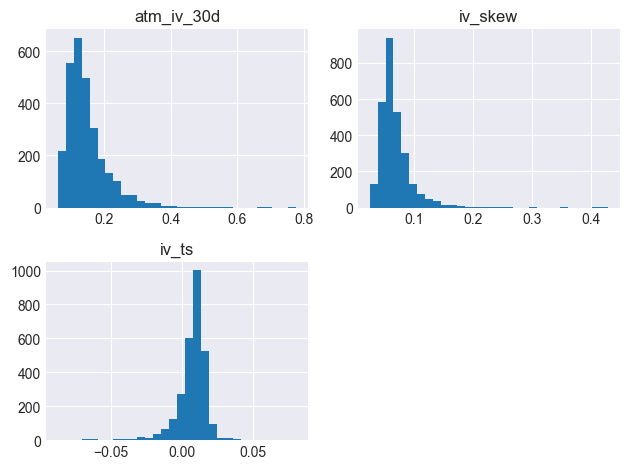

In [1151]:
X_iv_surface.hist(bins=30)
plt.tight_layout()
plt.show()

#### **Transformation Decisions**
- Apply `log` transform to: `iv_atm_60`, `iv_skew`.
- Apply Yeo-Johnson transform to: `iv_ts`

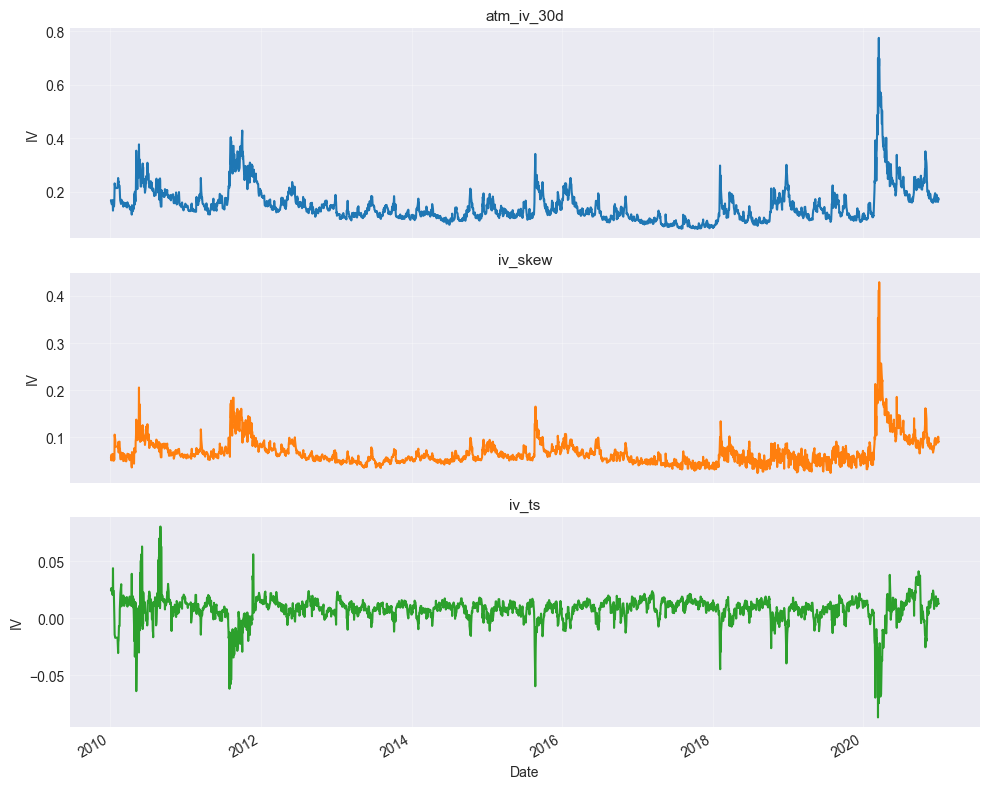

In [1152]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green, red

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for ax, col, c in zip(axes.flat, X_iv_surface.columns, colors):
    X_iv_surface[col].plot(ax=ax, lw=1.5, color=c)
    ax.set_title(col, fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_xlabel("Date")
    ax.set_ylabel("IV")
    
plt.tight_layout()
plt.show()

During market crashes the IV spike, skew steepens, the Iv-term strcutrue gets inverted.

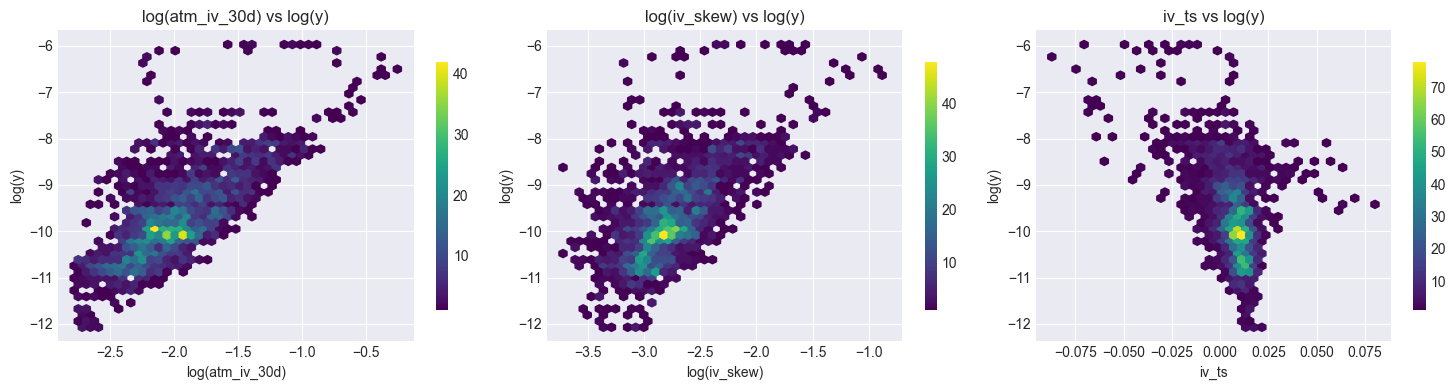

In [1161]:
plot_features_vs_target(X_iv_surface, y, log_features=["atm_iv_30d", "iv_skew"], figsize=(15,4), nrows=1, ncols=3)

### 4.2.3 Return-based Predictors  

Return-based predictors are essential for volatility: large moves in returns often coincide with large moves in volatility.  
However, daily returns are very noisy and our target is **21-day RV**, so we use **short rolling windows** (e.g. 5 trading days) to extract more stable signals.

- **Jumps (overnight moves)**  
  Large overnight returns (close\_{t−1} → open\_t) often coincide with news events and gap risk.  

- **Volatility clustering / persistence**  
  Rolling means of **absolute** and **squared** returns summarize the recent volatility regime.  

- **Asymmetry / leverage effect**  
  Periods dominated by large negative moves typically forecast **higher future RV** than periods with similar variance coming from positive moves.

- **Shape of the return distribution**  
  Rolling **realized skewness** and **kurtosis** capture asymmetry and tail thickness of recent returns which often coincides with stressed markets and higher forward volatility.

In [1307]:
def overnight_return(df, rth_start="09:30", rth_end="16:00"):
    """
    df: 5-min ES OHLCV with DatetimeIndex (exchange timezone)
    r_ov_t = log( Open_RTH_t / Close_RTH_{t-1} )
    """
    tod = df.index.strftime("%H:%M")
    rth = df[(tod >= rth_start) & (tod <= rth_end)].copy()

    # RTH open = first 'open' of the day, RTH close = last 'close' of the day
    daily_open  = rth.groupby(rth.index.date)["open"].first()
    daily_close = rth.groupby(rth.index.date)["close"].last()

    daily_open.index  = pd.to_datetime(daily_open.index)
    daily_close.index = pd.to_datetime(daily_close.index)

    ov = np.log(daily_open / daily_close.shift(1))
    ov.name = "overnight_ret"
    return ov.dropna()

def create_return_predictors(daily_returns: pd.Series, intraday_prices: pd.Series, h: int = 21) -> pd.DataFrame:
    ret_features = pd.DataFrame(index=daily_returns.index)

    # --- Overnight weekly overnihgt returns (jumps) ---
    ret_features["overnight_ret"] = overnight_return(intraday_prices).rolling(5).mean()

    # --- Volatility clustering ---
    ret_features["abs_r"] = daily_returns.abs().rolling(5).mean()
    ret_features["r2"] = daily_returns.pow(2).rolling(5).mean()

    # --- Asymmetry / leverage ----
    is_neg_ret = (daily_returns < 0).astype(int)
    ret_features["neg_r2"] = (is_neg_ret * ret_features["r2"]).rolling(5).mean()

    # --- Downside vs upside semivariance ---
    rolling = daily_returns.rolling(h)
    ret_features["down_var"] = rolling.apply(
        lambda x: (np.minimum(x, 0.0) ** 2).mean(), raw=False
    )
    ret_features["up_var"] = rolling.apply(
        lambda x: (np.maximum(x, 0.0) ** 2).mean(), raw=False
    )

    # --- Realized skewness & kurtosis ---
    ret_features["skew"] = rolling.apply(lambda x: ((x / x.std())**3).mean(), raw=False)
    ret_features["kurt"] = rolling.apply(lambda x: ((x / x.std())**4).mean(), raw=False)

    return ret_features

In [1308]:
X_returns = create_return_predictors(spx["returns"], es_5min, h=H)
X_returns = X_returns.reindex(y.index).ffill()
X_returns.agg(summary_stats)

overnight_ret        abs_r            r2       neg_r2      down_var  \
count       2830.000000  2830.000000  2.830000e+03  2826.000000  2.813000e+03   
mean           0.000306     0.007043  1.217114e-04     0.000057  6.564926e-05   
std            0.003318     0.006107  3.871663e-04     0.000197  1.870573e-04   
min           -0.030006     0.000581  3.711225e-07     0.000000  4.745243e-07   
max            0.023852     0.085571  8.078781e-03     0.004156  2.249933e-03   
skew          -0.408708     4.938071  1.351947e+01    13.307585  9.039184e+00   
kurtosis       9.990675    43.773244  2.319493e+02   218.484532  9.238763e+01   

               up_var         skew         kurt  
count     2813.000000  2813.000000  2813.000000  
mean         0.000057     0.191340     3.408498  
std          0.000124     0.992732     1.400154  
min          0.000003    -3.208464     1.457295  
max          0.001509     3.399189    13.121545  
skew         8.188091     0.199356     1.840437  
kurtosis    77.965242    -0.182521     5.160144

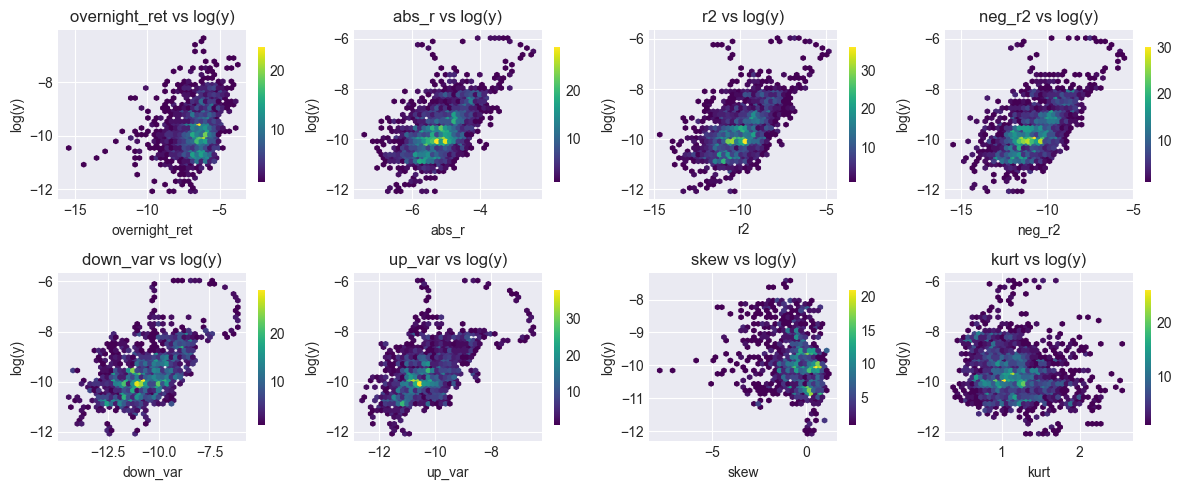

In [1323]:
plot_features_vs_target(np.log(X_returns), y, log_features=None, figsize=(12, 5), nrows=2, ncols=4)

### 4.2.4 Macro & Market Predictors  

This category combines **macro fundamentals** (rates, credit spreads) with **market-based measures** (volume, liquidity, realized correlations).  
Though generally less predictive than RV lags or IV signals, they can add value in stress regimes and are well suited to **machine learning models**, which can exploit non-linearities across a broader set of features.

#### Macro Fundamentals  

Here we include **slow-moving economic and financial variables** that capture the broader macro environment.  
These are unlikely to explain day-to-day fluctuations in volatility but may contain information about **regime shifts** (e.g. monetary tightening, credit stress) that affect forward realized volatility:  

- **Interest rate levels & term spreads**: Treasury yields (e.g. 3M, 2Y, 10Y), slope of the yield curve.  
- **Credit spreads**: Investment-grade and high-yield spreads, proxies for systemic financial stress.  

These predictors move more slowly than market-based signals but help identify **macro-driven volatility regimes** (e.g. high-rate environments, credit crises).

In [ ]:
# --- Load FRED API key from environment ---
load_dotenv()
FRED = None
try:
    from fredapi import Fred
    api_key = os.getenv("FRED_API_KEY")  # loaded from .env or system env
    if api_key:
        FRED = Fred(api_key=api_key)
        print("FRED API loaded.")
    else:
        print("No FRED API key found in environment. Macro features will be empty.")
except ImportError:
    print("fredapi not installed. Install with `pip install fredapi`.")

# --- Helper to fetch a single FRED series ---
def _fred_series(series_id, start=None, end=None):
    if FRED is None:
        return pd.Series(dtype=float, name=series_id)
    s = FRED.get_series(series_id, observation_start=start, observation_end=end)
    s = pd.Series(s, name=series_id)
    s.index = pd.to_datetime(s.index)
    return s

# --- Main macro feature builder ---
def create_macro_features(start="2005-01-01", end=None):
    # --- Treasury yields ---
    DGS10  = _fred_series("DGS10",  start, end).rename("DGS10")   # 10Y yield (%)
    DGS2   = _fred_series("DGS2",   start, end).rename("DGS2")    # 2Y yield (%)
    DGS3MO = _fred_series("DGS3MO", start, end).rename("DGS3MO")  # 3M yield (%)
    term_spread = (DGS10 - DGS3MO).rename("term_spread_10y_3m")

    # --- Credit spreads ---
    HY_OAS = _fred_series("BAMLH0A0HYM2", start, end).rename("HY_OAS")   # High Yield OAS (%)
    IG_OAS = _fred_series("BAMLC0A0CM",   start, end).rename("IG_OAS")   # IG OAS (%)

    df = pd.concat([DGS10, DGS2, DGS3MO, term_spread, HY_OAS, IG_OAS], axis=1).sort_index()

    # Business-day frequency; forward-fill for sparse macro data
    df = df.asfreq("B")
    df = df.ffill()

    return df

FRED API loaded.


In [58]:
X_macro = create_macro_features(start=start, end=end)

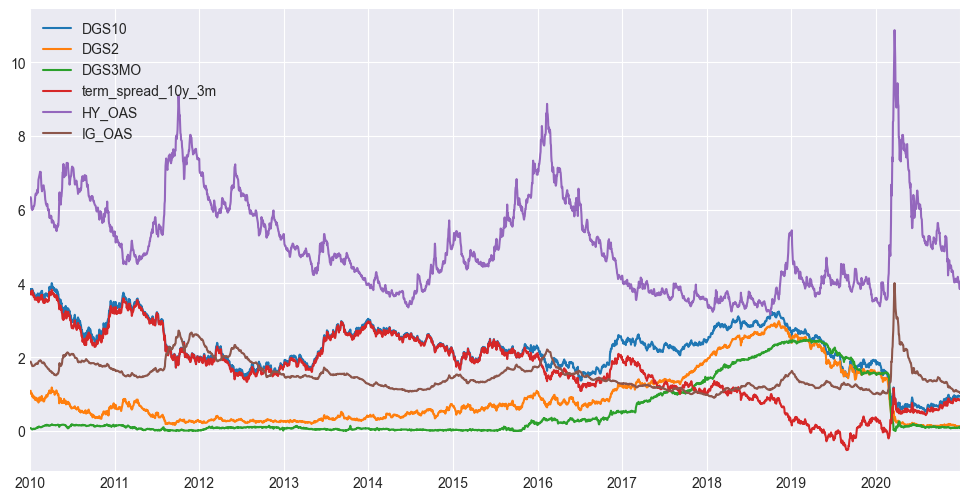

In [59]:
X_macro.plot(figsize=(12, 6))
plt.show()

In [60]:
X_macro.agg(summary_stats)

DGS10         DGS2       DGS3MO  term_spread_10y_3m  \
count     2869.000000  2869.000000  2869.000000         2869.000000   
mean         2.266386     0.909913     0.557640            1.708745   
std          0.691805     0.747697     0.777146            0.958607   
min          0.520000     0.110000     0.000000           -0.520000   
max          4.010000     2.980000     2.490000            3.830000   
skew        -0.240419     1.157739     1.337855           -0.083195   
kurtosis     0.193617     0.237751     0.238467           -0.607180   

               HY_OAS       IG_OAS  
count     2869.000000  2869.000000  
mean         5.045852     1.507881  
std          1.277921     0.387046  
min          3.160000     0.900000  
max         10.870000     4.010000  
skew         0.777234     1.348940  
kurtosis     0.097309     2.859696

In [62]:
X_macro = X_macro.reindex(y.index).ffill()

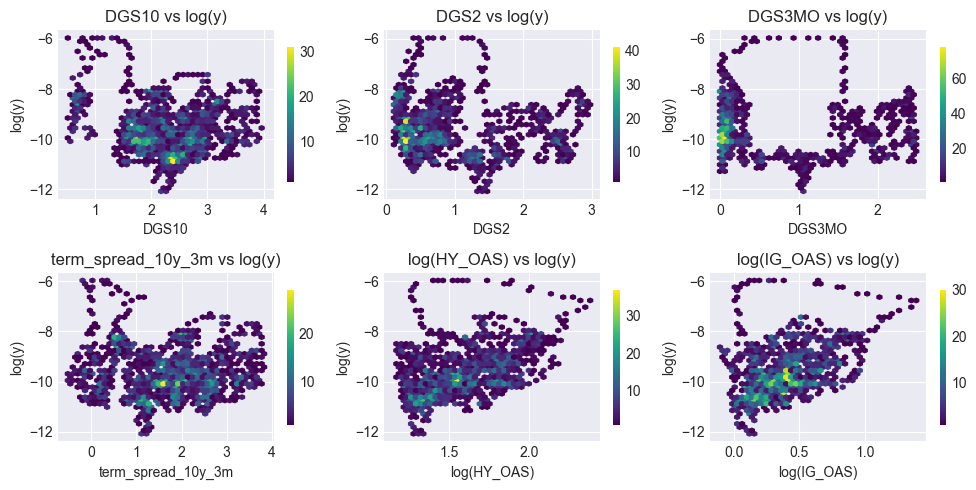

In [63]:
plot_features_vs_target(X_macro, y, log_features=["HY_OAS", "IG_OAS"], figsize=(10, 5), nrows=2, ncols=3)

In the 0 rates environment observed since the, short term interrest arets `DGS3MO` was mainly 0 up til `2017`so we decide to drop it.

In [1195]:
X_macro = X_macro.drop("DGS3MO", axis=1)

#### Market / Sentiment  

Here we include **market-implied and positioning-based indicators** that reflect how “nervous” or “complacent” investors are.  
They react faster than macro variables and can help identify **risk-on / risk-off regimes**, which affect both the level and persistence of future realized volatility:  

- **VIX**: benchmark measure of 30-day implied volatility on the S&P 500; a fast-moving barometer of market fear and near-term uncertainty.  
- **VVIX**: “volatility of volatility” index, capturing how uncertain the market is about future changes in VIX itself; often spikes in unstable vol regimes.  

These variables do not directly describe the asset’s own volatility process but provide **high-frequency information about crowd risk appetite**, making them natural **filters or conditioning variables** for IV–RV mispricing signals.

In [1233]:
def create_market_features(start: str, end: str) -> pd.DataFrame:
    vix = yf.download(["^VIX", "^VVIX"], start=start, end=end, auto_adjust=True, progress=False)[["Close"]]
    vix.columns = [tkr.replace("^", "") for _, tkr in vix.columns]
    vix = vix.rename(columns={"VIX": "VIX", "VVIX": "VVIX"}).sort_index()
    return vix

In [1234]:
X_market = create_market_features(start=start, end=end)
X_market = X_market.reindex(y.index).ffill()

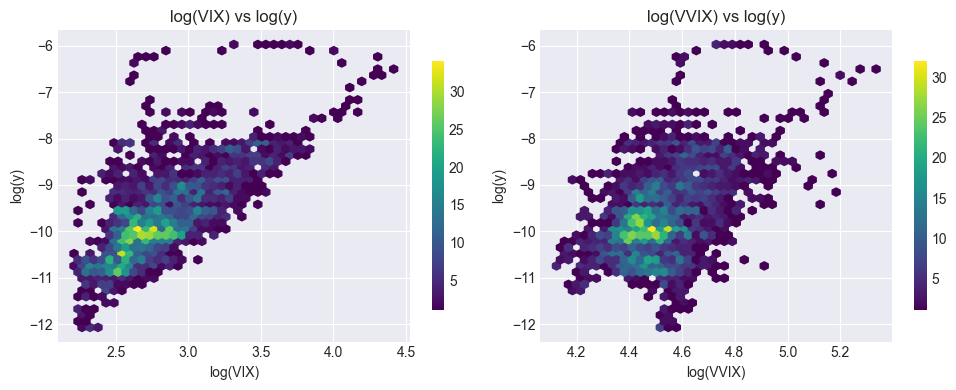

In [1240]:
plot_features_vs_target(X_market, y, log_features=["VIX", "VVIX"], figsize=(10, 4))

# **5. Feature Engineering**

We go beyond raw predictors (HAR lags, VIX, IV surface, credit spreads, etc.) by creating features that are more aligned with the forecasting task. The goal is to reduce noise, capture regime levels, and detect stress transitions that precede volatility spikes.  

- **Horizon-aligned smoothing:** The target is 21-day forward realized variance, so daily predictors are too noisy. We create regime-level signals that capture persistent volatility regimes instead of one-day noise.  

- **Regime shift / stress dynamics:** Volatility surges usually follow abrupt risk repricing. To capture this we add regime change features like momentum in VIX and SKEW as well as intercation effects like VVIX and VIX.

In [1354]:
def feature_engineering(
    X_core: pd.DataFrame,
    window_short: int = 5,
    window_long: int = 21,
    ewma_alpha: float = 0.2,
) -> pd.DataFrame:
    """
    Create X_eng features from economic predictors.
    Returns ONLY the X_eng features (not X_core itself).
    """
    X = X_core.copy()
    X_eng = {}

    # -------------------------------------------------
    # 1. Horizon-aligned smoothing (regime level)
    # -------------------------------------------------
    if "VIX" in X:
        X_eng["VIX_rm5"]   = X["VIX"].rolling(window_short, min_periods=1).mean()
        X_eng["VIX_rm21"]  = X["VIX"].rolling(window_long, min_periods=1).mean()
        X_eng["VIX_ewma"]  = X["VIX"].ewm(alpha=ewma_alpha, adjust=False).mean()

    if "RV_D" in X:
        X_eng["RV_D_ewma"] = X["RV_D"].ewm(alpha=ewma_alpha, adjust=False).mean()

    if "HY_OAS" in X:
        X_eng["HY_OAS_ewma"] = X["HY_OAS"].ewm(alpha=ewma_alpha, adjust=False).mean()

    # -------------------------------------------------
    # 2. Regime shift / stress dynamics
    # -------------------------------------------------
    if "VIX" in X:
        X_eng["dVIX_5d"] = X["VIX"] - X["VIX"].shift(window_short)

    if "iv_skew" in X:
        X_eng["dSkew_5d"] = X["iv_skew"] - X["iv_skew"].shift(window_short)

    if "atm_iv_30d" in X and "RV_M" in X:
        X_eng["iv_minus_realized"] = X["atm_iv_30d"] - X["RV_M"]

    if "VVIX" in X and "VIX" in X:
        X_eng["vvix_over_vix"] = X["VVIX"] / X["VIX"].replace(0, np.nan)

    if "VIX" in X and "HY_OAS" in X:
        X_eng["VIX_time_HY_OAS"] = X["VIX"] * X["HY_OAS"] 
    
    if "RV_D" in X:
        X_eng["RV_D_rollvol5"] = X["RV_D"].rolling(5).std()
        X_eng["RV_D_rollvol21"] = X["RV_D"].rolling(21).std()

    # -------------------------------------------------
    # 3. Assemble into DataFrame
    # -------------------------------------------------
    X_eng = pd.DataFrame(X_eng, index=X.index)

    return X_eng

In [ ]:
X_core = pd.concat([X_har, X_iv_surface, X_macro, X_returns, X_market], axis=1)
X_eng = feature_engineering(X_core)
X = pd.concat([X_core, X_eng], axis=1)
X = X.dropna(axis=0)

core_features = X_core.columns.tolist()
eng_features = X_eng.columns.tolist()

X_eng.agg(summary_stats)

VIX_rm5     VIX_rm21     VIX_ewma    RV_D_ewma  HY_OAS_ewma  \
count     2835.000000  2835.000000  2835.000000  2835.000000  2835.000000   
mean        17.971053    17.960360    17.969347     0.000109     5.049248   
std          7.259670     6.853001     7.046994     0.000240     1.263522   
min          9.376000     9.800000     9.614762     0.000004     3.233705   
max         74.618001    61.258572    65.811602     0.003825     9.377609   
skew         2.536454     2.301621     2.402397     9.136190     0.713000   
kurtosis    10.793452     8.074845     9.234084   104.384005    -0.209626   

              dVIX_5d     dSkew_5d  iv_minus_realized  vvix_over_vix  \
count     2830.000000  2830.000000        2815.000000    2835.000000   
mean         0.005693     0.000061           0.149081       5.655410   
std          3.593055     0.018515           0.066756       1.435551   
min        -21.100002    -0.225512           0.062051       2.054459   
max         35.850002     0.234780           0.774351      10.316940   
skew         1.683577     1.018086           2.616658       0.373912   
kurtosis    14.954005    37.015940          12.701030       0.257500   

          VIX_time_HY_OAS  RV_D_rollvol5  RV_D_rollvol21  
count         2835.000000    2831.000000     2815.000000  
mean            97.091306       0.000081        0.000109  
std             68.567904       0.000181        0.000209  
min             30.979201       0.000001        0.000003  
max            707.040000       0.002710        0.002145  
skew             3.348497       8.036214        6.563821  
kurtosis        18.603871      86.449242       52.444094

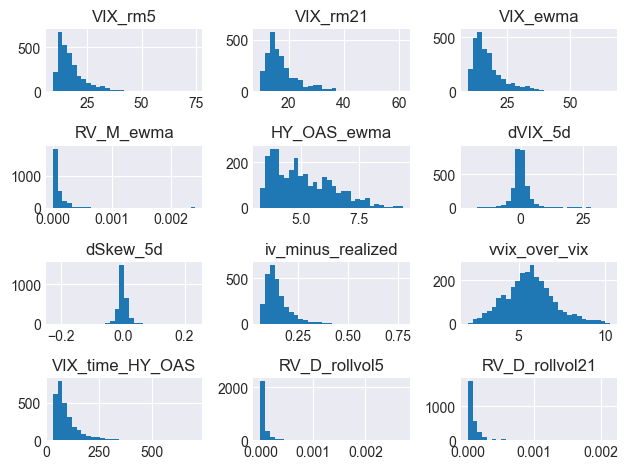

In [1243]:
X_eng.hist(bins=30)
plt.tight_layout()
plt.show()

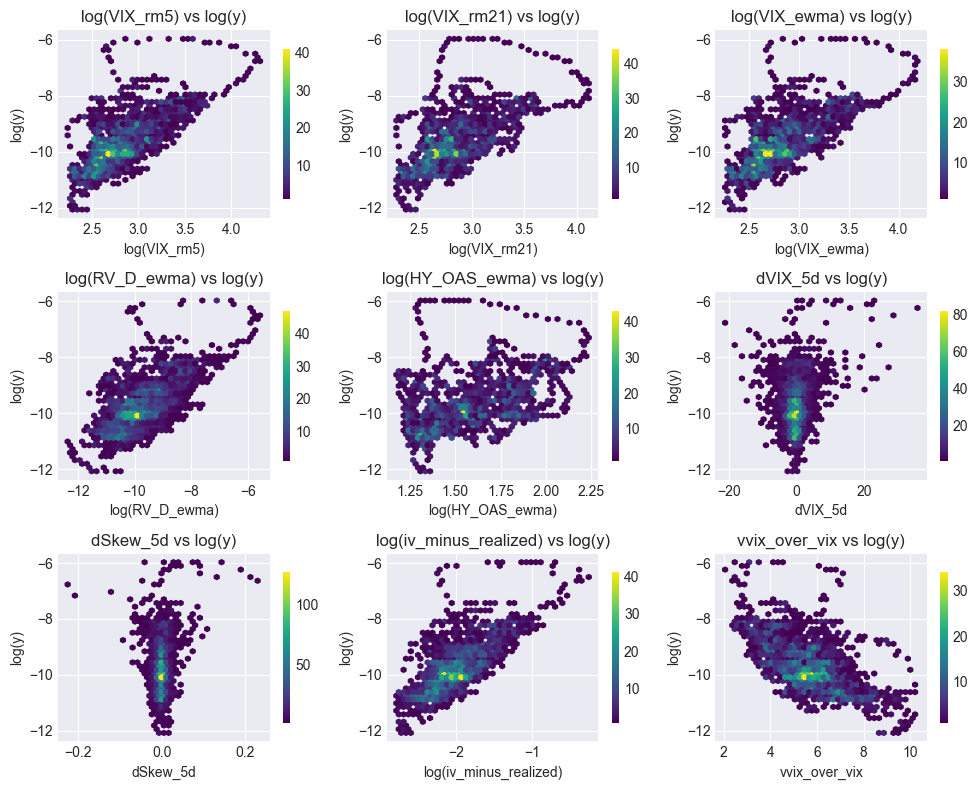

In [1338]:
plot_features_vs_target(X_eng, y, log_features=list(set(eng_features) - set(["dVIX_5d", "dSkew_5d", "vvix_over_vix"])), figsize=(10, 8), nrows=3, ncols=3)

# **6. Data Preprocessing**

We inspect each predictor’s distribution (shape, skewness, tail heaviness) and only transform when necessary.  
The goal is to make features more symmetric and well-behaved for regression and machine learning.

We rely on simple, interpretable transforms:

- **log** for strictly positive, heavy-right-tailed variables (e.g. VIX, kurtosis proxies),
- **sqrt** for variance-like or squared quantities (e.g. squared returns),
- **winsorization** (clipping extreme quantiles) to tame rare but extreme outliers.
- **scaling** apply standard scaling to put all the features on the same scale (essential for linear models)

This step is not about “cheating the target,” but about stabilizing scale and reducing extreme tails so the model trains on cleaner signals.  
Since most predictors are already smoothed (HAR averages, rolling VIX, EWMA spreads, etc.), we mainly need to correct **heavy right tails** and **occasional extreme shocks** rather than aggressively reshape every feature.

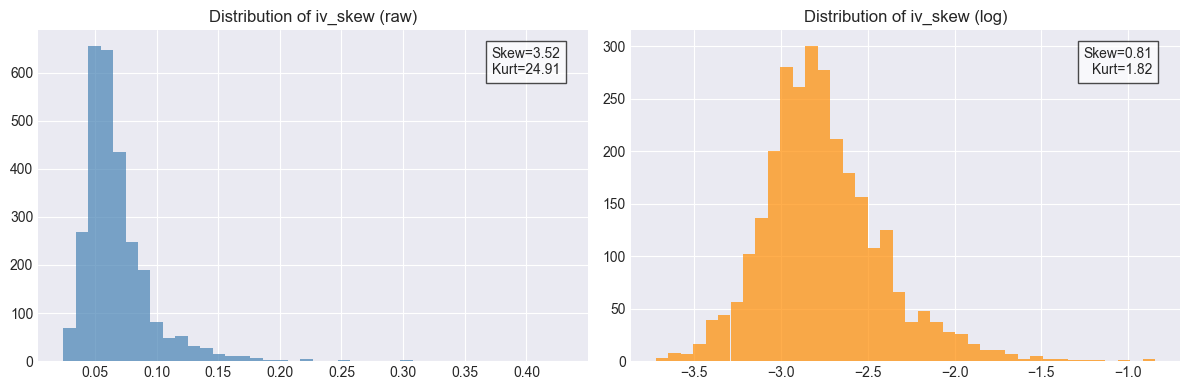

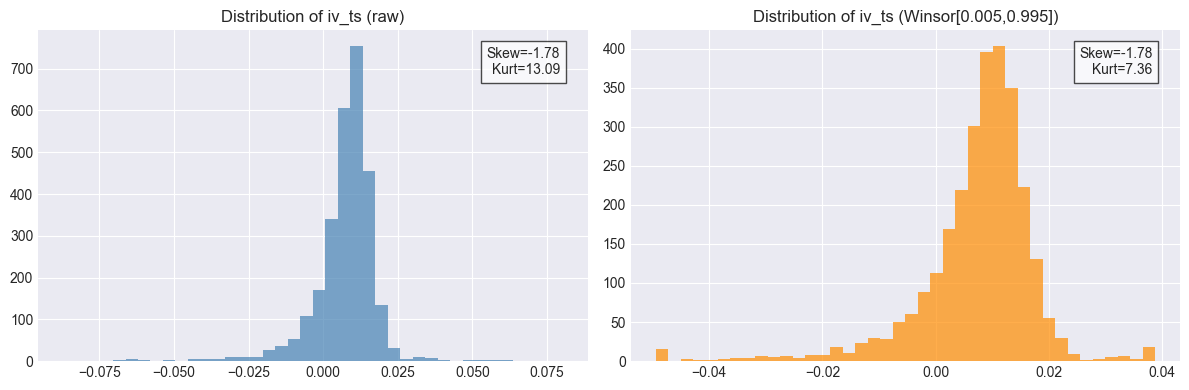

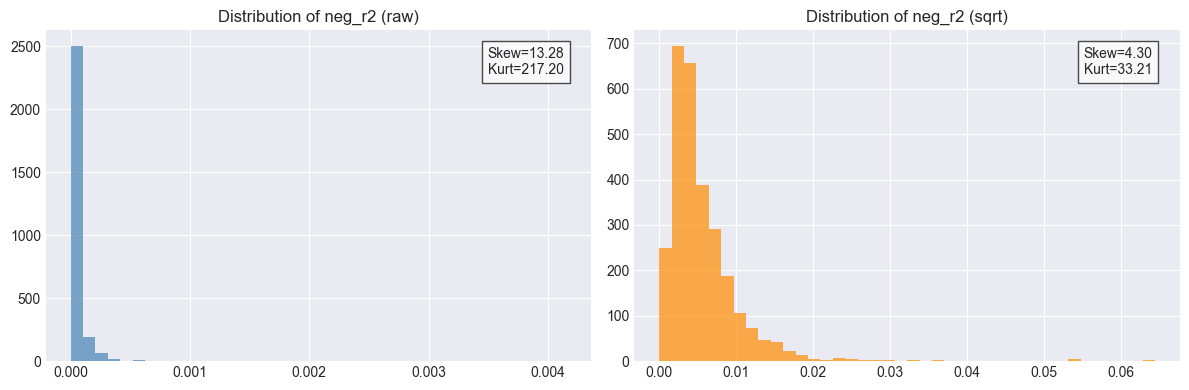

In [1422]:
ph.plot_transform_demo(X["iv_skew"], use_log=True)
ph.plot_transform_demo(X["iv_ts"], winsorize=(0.005, 0.995))
ph.plot_transform_demo(X["neg_r2"], use_sqrt=True)

## Data processsing pipeline

In [ ]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, eps=1e-8):
        self.eps = eps

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.log(np.clip(X, self.eps, None))

    def set_output(self, *, transform=None):
        return self

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array([f"log_feature_{i}" for i in range(self.n_features_in_)])
        return np.array([f"log__{feat}" for feat in input_features])


class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.n_features_in_ = None

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.sqrt(np.clip(X, 0.0, None))

    def set_output(self, *, transform=None):
        return self

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array([f"sqrt_feature_{i}" for i in range(self.n_features_in_)])
        return np.array([f"sqrt__{feat}" for feat in input_features])


class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.005, upper=0.995):
        self.lower = lower
        self.upper = upper

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.q_low_ = np.quantile(X, self.lower, axis=0)
        self.q_high_ = np.quantile(X, self.upper, axis=0)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.q_low_, self.q_high_)

    def set_output(self, *, transform=None):
        return self

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array([f"winsor_feature_{i}" for i in range(self.n_features_in_)])
        return np.array([f"winsor__{feat}" for feat in input_features])


class DataProcessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 log_features=None,
                 sqrt_features=None,
                 winsor_features=None,
                 scale=True):
        """
        winsor_features: list of ( [low, high], [col1, col2, ...] )

        Each feature must appear in at most ONE of:
        - log_features
        - sqrt_features
        - any winsor_features group
        Others are passed through unchanged.
        """
        self.log_features = log_features or []
        self.sqrt_features = sqrt_features or []
        self.winsor_features = winsor_features or []  # list of (quantiles, cols)
        self.scale = scale

        self.preprocessor_ = None
        self.pipeline_ = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X).copy()
        all_cols = list(X_df.columns)

        # collect all winsor columns
        winsor_cols_all = []
        for (q_range, cols) in self.winsor_features:
            winsor_cols_all.extend(cols)

        used = set(self.log_features) | set(self.sqrt_features) | set(winsor_cols_all)
        passthrough_cols = [c for c in all_cols if c not in used]

        transformers = []

        # log
        if self.log_features:
            transformers.append(("log", LogTransformer(), self.log_features))

        # sqrt
        if self.sqrt_features:
            transformers.append(("sqrt", SqrtTransformer(), self.sqrt_features))

        # winsor groups
        for (q_range, cols) in self.winsor_features:
            if not cols:
                continue
            low, high = q_range
            name = f"winsor_{low}_{high}".replace(".", "p")
            transformers.append(
                (name, Winsorizer(lower=low, upper=high), cols)
            )

        # passthrough
        if passthrough_cols:
            transformers.append(
                ("passthrough", "passthrough", passthrough_cols)
            )

        self.preprocessor_ = ColumnTransformer(
            transformers=transformers,
            remainder="drop",
            verbose_feature_names_out=False,
        )

        steps = [("preprocess", self.preprocessor_)]
        if self.scale:
            steps.append(("scaler", StandardScaler()))

        self.pipeline_ = Pipeline(steps)
        self.pipeline_.fit(X_df, y)

        # store feature names after preprocess step (before scaler)
        # note: get_feature_names_out is available from sklearn >=1.0-ish
        try:
            self.feature_names_out_ = self.preprocessor_.get_feature_names_out()
        except AttributeError:
            self.feature_names_out_ = None

        return self

    def transform(self, X):
        X_df = pd.DataFrame(X).copy()
        return self.pipeline_.transform(X_df)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

    def get_feature_names_out(self):
        """
        Returns names of features *after* preprocess (before scaling).
        If scaling is applied, scaler doesn't change dimensionality,
        so names still line up.
        """
        return self.feature_names_out_

## Apply the appropiate transformations

In [1417]:
log_features = [
    "RV_D", "RV_W", "RV_M", "RV_D_ewma",
    "abs_r", "r2", "down_var", "up_var", "skew", "kurt",
    "VIX", "VVIX", "VIX_rm5", "VIX_rm21", "VIX_ewma",
    "atm_iv_30d", "iv_skew", "iv_minus_realized",
    "VIX_time_HY_OAS", 
    "RV_D_rollvol5", "RV_D_rollvol21"
]

sqrt_features = ["neg_r2"]

winsor_features = [
    ([0.005, 0.995], ["iv_ts", "overnight_ret"]),
    ([0.001, 0.995], ["dVIX_5d", "dSkew_5d"])
]

processor = DataProcessor(
    log_features=log_features,
    sqrt_features=sqrt_features,
    winsor_features=winsor_features,
    scale=True
)

X_proc = processor.fit_transform(X)
X_proc = pd.DataFrame(X_proc, index=X.index, columns=processor.get_feature_names_out())

cols_sample = np.random.choice(X_proc.columns, size=8, replace=False)
X_proc[cols_sample].agg(summary_stats)

log__VIX   log__up_var     log__RV_D  winsor__overnight_ret  \
count     2.813000e+03  2.813000e+03  2.813000e+03           2.813000e+03   
mean      3.334221e-16  1.111407e-16 -4.041480e-17           2.336481e-17   
std       1.000178e+00  1.000178e+00  1.000178e+00           1.000178e+00   
min      -1.819088e+00 -2.500157e+00 -3.873082e+00          -3.782877e+00   
max       4.729766e+00  4.221518e+00  4.062046e+00           4.500141e+00   
skew      9.634953e-01  7.798469e-01  2.720105e-01           1.756464e-02   
kurtosis  1.126383e+00  1.460205e+00  5.874265e-01           3.469971e+00   

               log__r2  sqrt__neg_r2  log__iv_skew  log__VIX_rm5  
count     2.813000e+03  2.813000e+03  2.813000e+03  2.813000e+03  
mean     -7.678812e-16  1.010370e-17  2.930073e-16  3.132147e-16  
std       1.000178e+00  1.000178e+00  1.000178e+00  1.000178e+00  
min      -3.764729e+00 -1.102304e+00 -2.794782e+00 -1.779659e+00  
max       3.998548e+00  1.161344e+01  5.543378e+00  4.493073e+00  
skew      1.533141e-01  4.304240e+00  8.113422e-01  9.674130e-01  
kurtosis  4.301804e-01  3.327449e+01  1.820835e+00  1.118786e+00

In [1523]:
y = create_forward_target(daily_rv, horizon=21)

data = pd.concat([X_proc, y], axis=1)
data = data.dropna()

X_clean = data[X_proc.columns]
y_clean = data[y.name]

## Correlation / redundancy check

By removing very redundent features we make the feature imporatnce in the enxt section for stable.

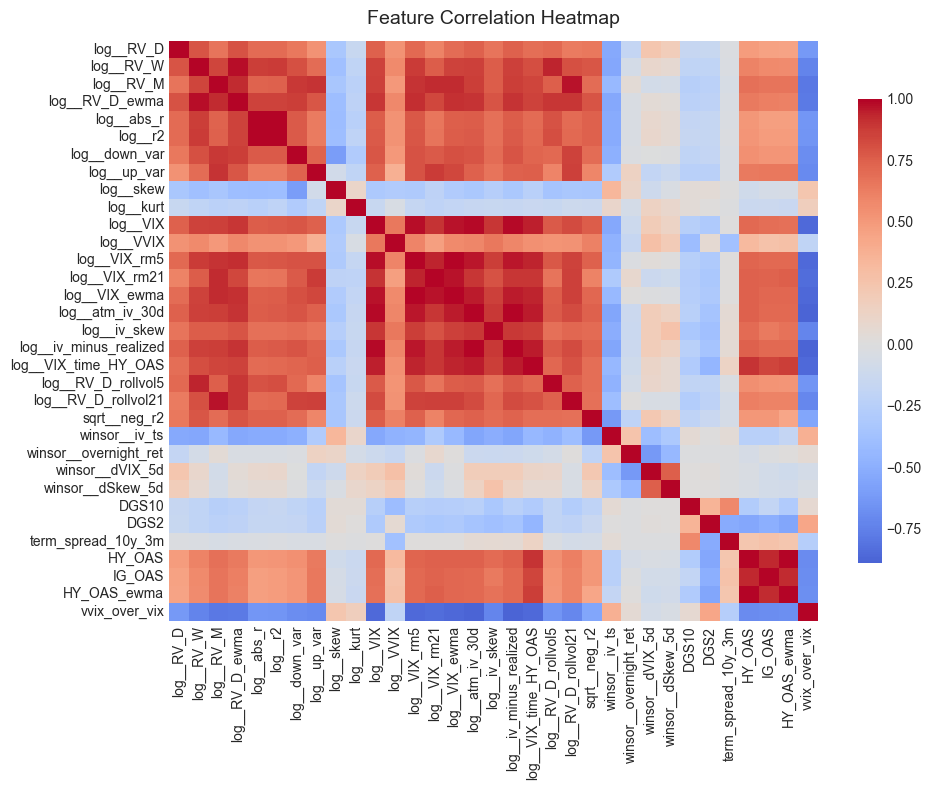

In [1524]:
corr = X_clean.corr()

plt.figure(figsize=(10, 8))  # adjust size

sns.heatmap(
    corr,
    cmap="coolwarm",        
    center=0,                   
    cbar_kws={"shrink": .8}
)

plt.title("Feature Correlation Heatmap", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

In [1525]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_pairs = (
    upper.stack()
         .loc[lambda s: s > 0.95] 
         .sort_values(ascending=False)
)
print(high_pairs)

log__atm_iv_30d         log__iv_minus_realized    0.999999
log__VIX_rm5            log__VIX_ewma             0.994107
HY_OAS                  HY_OAS_ewma               0.990606
log__abs_r              log__r2                   0.987160
log__VIX                log__atm_iv_30d           0.984047
                        log__iv_minus_realized    0.983999
                        log__VIX_rm5              0.972769
log__RV_W               log__RV_D_ewma            0.970479
log__VIX                log__VIX_ewma             0.966937
log__VIX_rm21           log__VIX_ewma             0.965546
log__RV_M               log__RV_D_rollvol21       0.964809
log__VIX_rm5            log__atm_iv_30d           0.960073
                        log__iv_minus_realized    0.959925
log__VIX_ewma           log__atm_iv_30d           0.955040
                        log__iv_minus_realized    0.954847
log__atm_iv_30d         log__VIX_time_HY_OAS      0.953364
log__iv_minus_realized  log__VIX_time_HY_OAS      0.9533

In [ ]:
corr_features_to_drop = [
    "log__atm_iv_30d", "log__iv_minus_realized", "log__r2",
    "log__VIX_rm5", "log__RV_D_ewma", "HY_OAS", "log__VIX_ewma", "log__RV_D_rollvol21"
]
X_clean = X_clean.drop(corr_features_to_drop, axis=1)

# **7. Feature Importance & Stability Analysis**

Here the obecjtive of this seciton is too udnertsand whihc features are more relevent to forecast the forward 21-D RV and whihc ones are more stabel across regimes. We perform this analysis to identify which features are most stable, taking into account the strength of the relationship with the target (strong predictors well documented in the litterature like RV lags and VIX, comapred to mild/weak ones like macro/sentiment predictors). The obective is not to perform a fetaure seleciton in the strictest sense by jsut accounting for the geenralziaiton error but using teh geenralizaiton error across regimes to guide us about the choice of parsimonious feature sets and remove the completeelty irrelevent features.

For that we look at several imporatnce metrics, in and out of samples foer both linear and non-linear models taking into account importance for non-linear models with and withiut interaction effects.

## 7.1 Purged KFold Cross Validation

Here we define this class as we will need it analyse feature importance across regiesm. In fact, soemthing speciial with financial time series data in geenral is the non-stationaty, thus to decide and undertsand which feature are teh msot imporantn we are gonna anlsyse how they behave across regimes. In order to be able to check the stability across the all reserahcv set (from 2010 to 2020) we perform a K-fold Cross Vadliation that we purge and embargo to remove the overlapping 21-D Rv target as well as rolling windows overllaping between the trainign and test sets.

In [1529]:
class PurgedKFold(BaseCrossValidator):
    """
    Purged K-Fold cross-validator for time series.

    - Folds are contiguous in time (no shuffle).
    - Around each test fold we:
        * purge `purge_gap` samples immediately before and after the test fold
        * embargo a fraction `embargo` of samples AFTER the test fold

    This is useful when targets or features use lookbacks / lookaheads
    (e.g. rolling RV), so that training data does not leak future info
    from the test window.

    Parameters
    ----------
    n_splits : int, default=5
        Number of folds.
    purge_gap : int, default=0
        Number of samples to drop from the training set immediately
        before and after the test block in index space.
    embargo : float, default=0.0
        Fraction (0..1) of the dataset to embargo *after* each test fold.
        Example: embargo=0.01 with 10,000 samples → next 100 samples
        after the test block are removed from the training set.
    """

    def __init__(self, n_splits=5, purge_gap=0, embargo=0.0):
        if n_splits < 2:
            raise ValueError("n_splits must be at least 2.")
        if purge_gap < 0:
            raise ValueError("purge_gap must be >= 0.")
        if not (0.0 <= embargo < 1.0):
            raise ValueError("embargo must be in [0.0, 1.0).")

        self.n_splits = n_splits
        self.purge_gap = purge_gap
        self.embargo = embargo

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        """
        Generate train/test indices.

        X is assumed to be time-ordered already: X[0] is earliest,
        X[-1] is latest.
        """
        n_samples = len(X)
        indices = np.arange(n_samples)

        # build contiguous folds (like standard KFold with shuffle=False)
        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
        fold_sizes[: n_samples % self.n_splits] += 1

        current = 0
        folds = []
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            folds.append(indices[start:stop])
            current = stop

        n_embargo = int(np.floor(n_samples * self.embargo))

        for test_idx in folds:
            test_start = test_idx[0]
            test_end = test_idx[-1]

            # start with all indices
            train_idx = indices.copy()

            # remove test indices themselves
            train_idx = np.setdiff1d(train_idx, test_idx, assume_unique=False)

            # purge region before and after test
            if self.purge_gap > 0:
                left = max(test_start - self.purge_gap, 0)
                right = min(test_end + self.purge_gap, n_samples - 1)
                purge_region = np.arange(left, right + 1)
                train_idx = np.setdiff1d(train_idx, purge_region, assume_unique=False)

            # embargo region after test
            if n_embargo > 0:
                emb_start = min(test_end + 1, n_samples)
                emb_end = min(emb_start + n_embargo, n_samples)
                if emb_start < emb_end:
                    embargo_region = np.arange(emb_start, emb_end)
                    train_idx = np.setdiff1d(train_idx, embargo_region, assume_unique=False)

            yield np.sort(train_idx), np.sort(test_idx)

### Extract the best $\alpha$ for Lasso fitting usign Purged KFold Cross validation

In [1708]:
from sklearn.linear_model import Lasso

purged_cv = PurgedKFold(
    n_splits=5,    # ≈ 1-year val per fold
    purge_gap=21,   # your 21-day horizon
    embargo=0.01,   # small embargo 
)

lasso_cv = LassoCV(
        alphas=np.logspace(-4, 0, 30),
        cv=purged_cv,
        max_iter=100000,
        n_jobs=-1
)
lasso_cv.fit(X_clean, y_clean)
alpha_star = lasso_cv.alpha_

In [1698]:
def plot_mean_std_importance_ax(
    ax, values, feature_names, title, top_n=20, abs_values=False
):
    """
    Plot mean ± std importance on a given axis.
    values: (n_folds, n_features)
    """
    vals = np.array(values)
    if abs_values:
        vals = np.abs(vals)

    mean_imp = vals.mean(axis=0)
    std_imp = vals.std(axis=0)

    df = pd.DataFrame({
        "feature": feature_names,
        "mean": mean_imp,
        "std": std_imp,
    })

    df = df.reindex(df["mean"].abs().sort_values(ascending=False).index)
    df_top = df.head(top_n)

    ax.barh(df_top["feature"], df_top["mean"], xerr=df_top["std"])
    ax.invert_yaxis()
    ax.set_xlabel("Mean importance" + (" (|value|)" if abs_values else ""))
    ax.set_title(title)


## 7.2 In-model stability analysis with substitution effects

Here we use Mean-Decrease impurity as defined in De Prado (Machine Learning for Trading) for non-linear models and weigths given me a Lasos fit for linear models.

In [1699]:
def in_sample_stability(X, y, lasso, rf, cv):
    """
    In-model stability: coefficients for Lasso, Mean Decrease Impurity for RF
    across folds.
    """
    n_features = X.shape[1]
    n_folds = cv.get_n_splits(X, y)

    coefs = np.zeros((n_folds, n_features))
    rf_fi = np.zeros((n_folds, n_features))

    for fold, (tr, val) in enumerate(cv.split(X, y)):
        X_tr, y_tr = X.iloc[tr], y.iloc[tr]

        lasso.fit(X_tr, y_tr)
        rf.fit(X_tr, y_tr)

        coefs[fold, :] = lasso.coef_
        rf_fi[fold, :] = rf.feature_importances_

    return coefs, rf_fi

In [1709]:
lasso = Lasso(alpha=alpha_star)

feature_names = X_clean.columns

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=5,
    n_jobs=-1,
)

coefs, rf_fi = in_sample_stability(X_clean, y_clean, lasso, rf, purged_cv)

## OOS permutation importance (Lasso / RF)

In [1705]:
def oos_feature_importance(X, y, lasso, rf, cv, n_repeats=30, scoring="neg_mean_squared_error", random_state=0):
    """
    OOS permutation importance MDA (Mean Decrease Accuracy) computed on the validation folds.
    """
    n_features = X.shape[1]
    n_folds = cv.get_n_splits(X, y)

    pi_lasso = np.zeros((n_folds, n_features))
    pi_rf = np.zeros((n_folds, n_features))

    for fold, (tr, val) in enumerate(cv.split(X, y)):
        X_tr, y_tr = X.iloc[tr], y.iloc[tr]
        X_val, y_val = X.iloc[val], y.iloc[val]

        lasso.fit(X_tr, y_tr)
        rf.fit(X_tr, y_tr)

        # Lasso PI on validation
        r_lasso = permutation_importance(
            lasso, X_val, y_val,
            scoring=scoring,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=-1,
        )
        pi_lasso[fold, :] = r_lasso.importances_mean

        # RF PI on validation
        r_rf = permutation_importance(
            rf, X_val, y_val,
            scoring=scoring,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=-1,
        )
        pi_rf[fold, :] = r_rf.importances_mean

    return pi_lasso, pi_rf

In [1712]:
pi_lasso, pi_rf = oos_feature_importance(X_clean, y_clean, lasso, rf, purged_cv, scoring="neg_mean_squared_error")

## 5 Folds Neg MSE

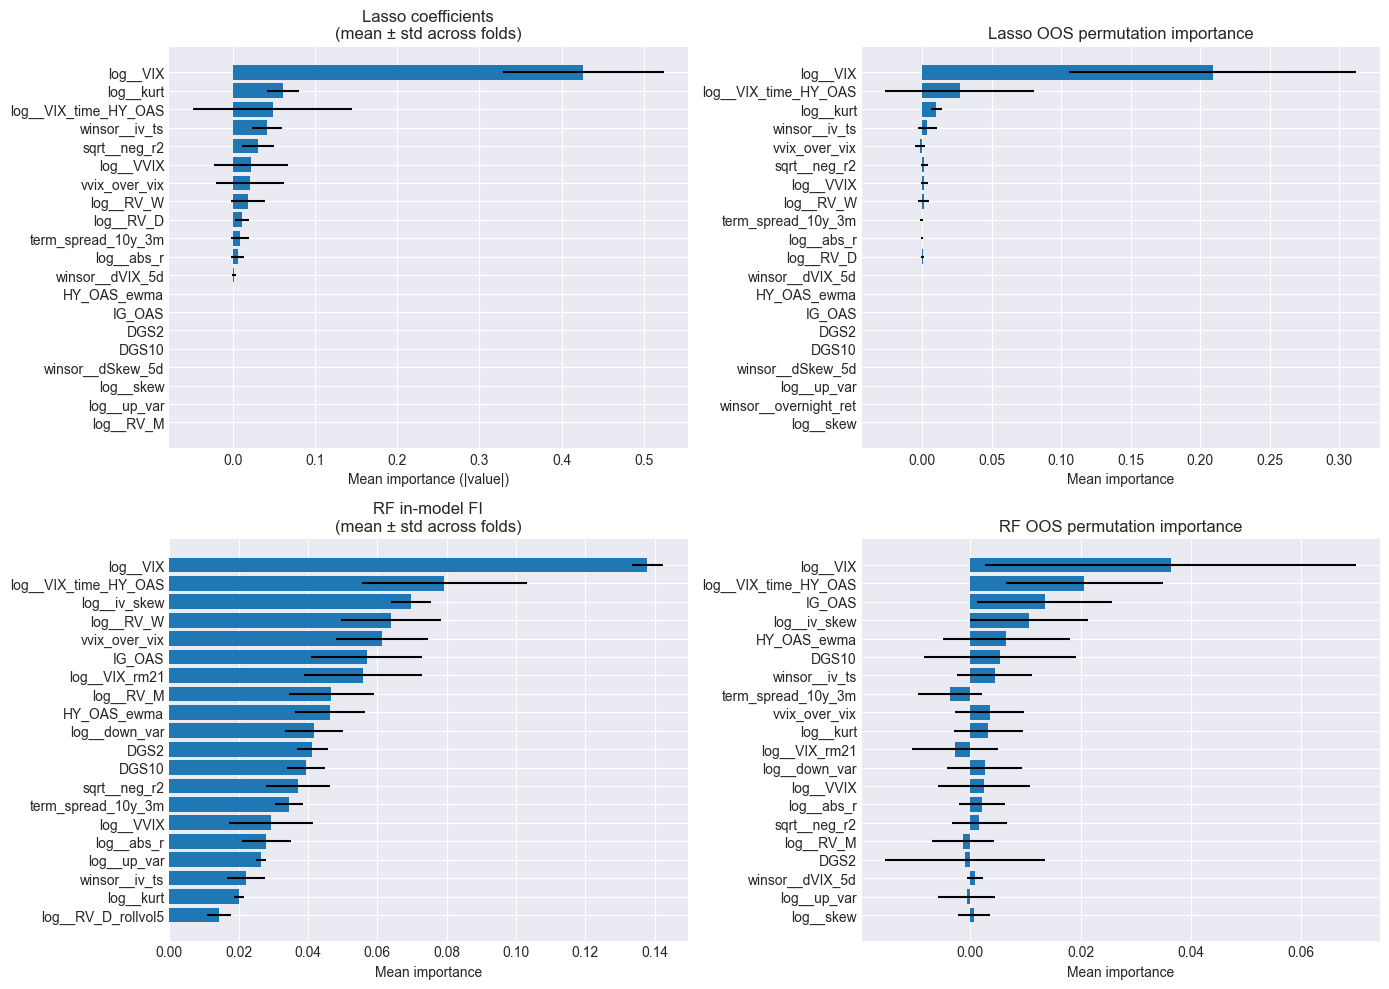

In [1713]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Lasso coefficients
plot_mean_std_importance_ax(
    axes[0, 0],
    coefs,
    feature_names,
    title="Lasso coefficients\n(mean ± std across folds)",
    top_n=20,
    abs_values=True,
)

# 2) RF in-model FI (MDI)
plot_mean_std_importance_ax(
    axes[1, 0],
    rf_fi,
    feature_names,
    title="RF in-model FI\n(mean ± std across folds)",
    top_n=20,
    abs_values=False,
)

# 3) Lasso OOS permutation importance
plot_mean_std_importance_ax(
    axes[0, 1],
    pi_lasso,
    feature_names,
    title="Lasso OOS permutation importance",
    top_n=20,
    abs_values=False,
)

# 4) RF OOS permutation importance
plot_mean_std_importance_ax(
    axes[1, 1],
    pi_rf,
    feature_names,
    title="RF OOS permutation importance",
    top_n=20,
    abs_values=False,
)

plt.tight_layout()
plt.show()

## 5 Folds R2

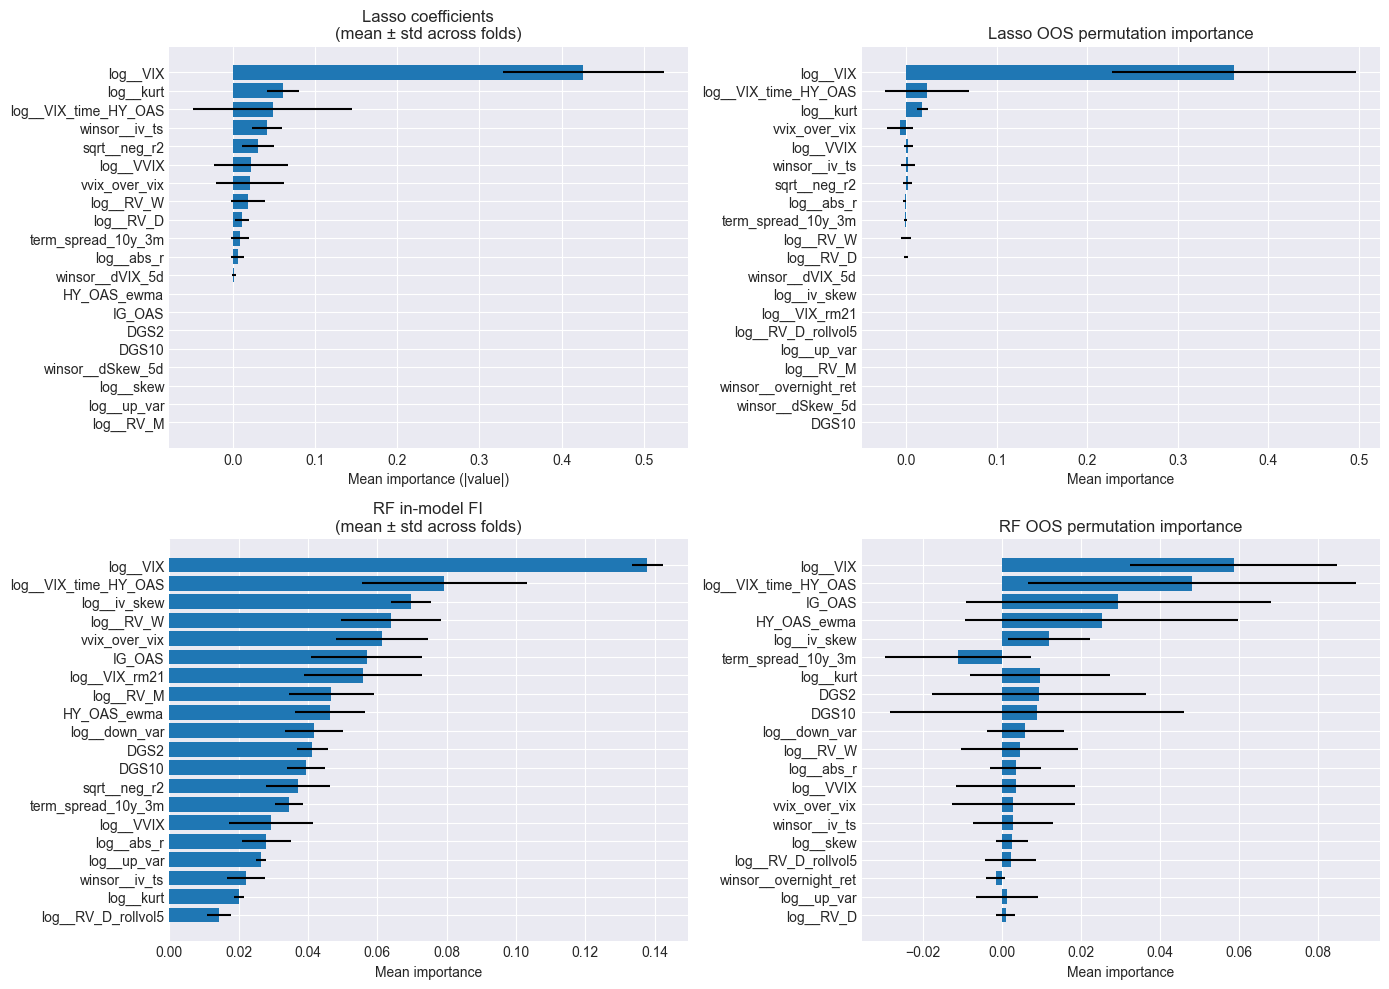

In [1711]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Lasso coefficients
plot_mean_std_importance_ax(
    axes[0, 0],
    coefs,
    feature_names,
    title="Lasso coefficients\n(mean ± std across folds)",
    top_n=20,
    abs_values=True,
)

# 2) RF in-model FI (MDI)
plot_mean_std_importance_ax(
    axes[1, 0],
    rf_fi,
    feature_names,
    title="RF in-model FI\n(mean ± std across folds)",
    top_n=20,
    abs_values=False,
)

# 3) Lasso OOS permutation importance
plot_mean_std_importance_ax(
    axes[0, 1],
    pi_lasso,
    feature_names,
    title="Lasso OOS permutation importance",
    top_n=20,
    abs_values=False,
)

# 4) RF OOS permutation importance
plot_mean_std_importance_ax(
    axes[1, 1],
    pi_rf,
    feature_names,
    title="RF OOS permutation importance",
    top_n=20,
    abs_values=False,
)

plt.tight_layout()
plt.show()

## 10 Folds R2

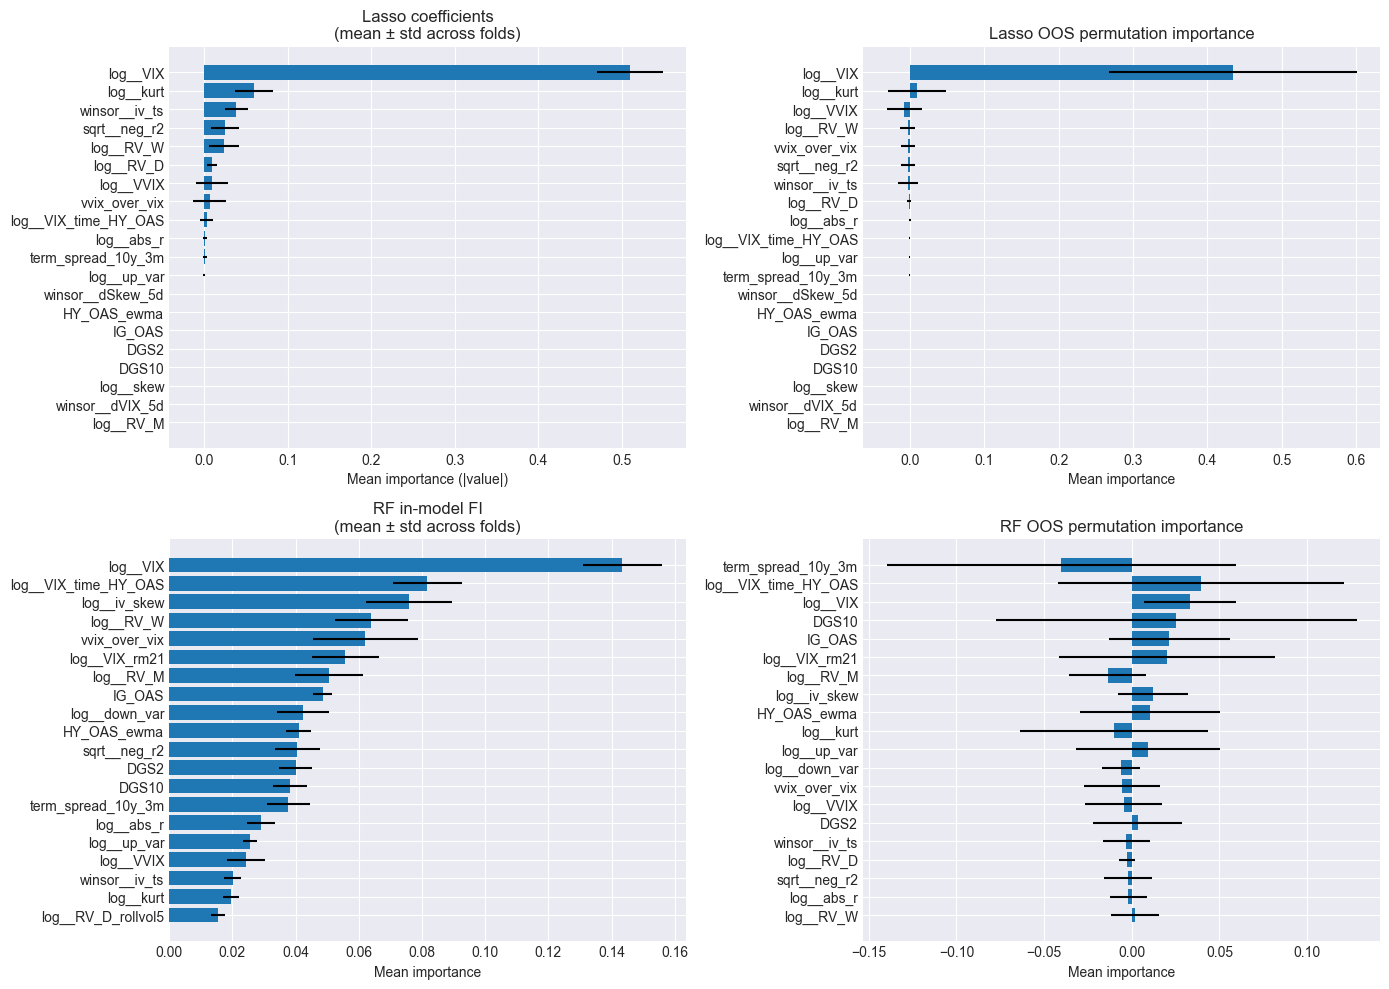

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Lasso coefficients
plot_mean_std_importance_ax(
    axes[0, 0],
    coefs,
    feature_names,
    title="Lasso coefficients\n(mean ± std across folds)",
    top_n=20,
    abs_values=True,
)

# 2) RF in-model FI (MDI)
plot_mean_std_importance_ax(
    axes[1, 0],
    rf_fi,
    feature_names,
    title="RF in-model FI\n(mean ± std across folds)",
    top_n=20,
    abs_values=False,
)

# 3) Lasso OOS permutation importance
plot_mean_std_importance_ax(
    axes[0, 1],
    pi_lasso,
    feature_names,
    title="Lasso OOS permutation importance",
    top_n=20,
    abs_values=False,
)

# 4) RF OOS permutation importance
plot_mean_std_importance_ax(
    axes[1, 1],
    pi_rf,
    feature_names,
    title="RF OOS permutation importance",
    top_n=20,
    abs_values=False,
)

plt.tight_layout()
plt.show()

## 10 Folds Neg MSE

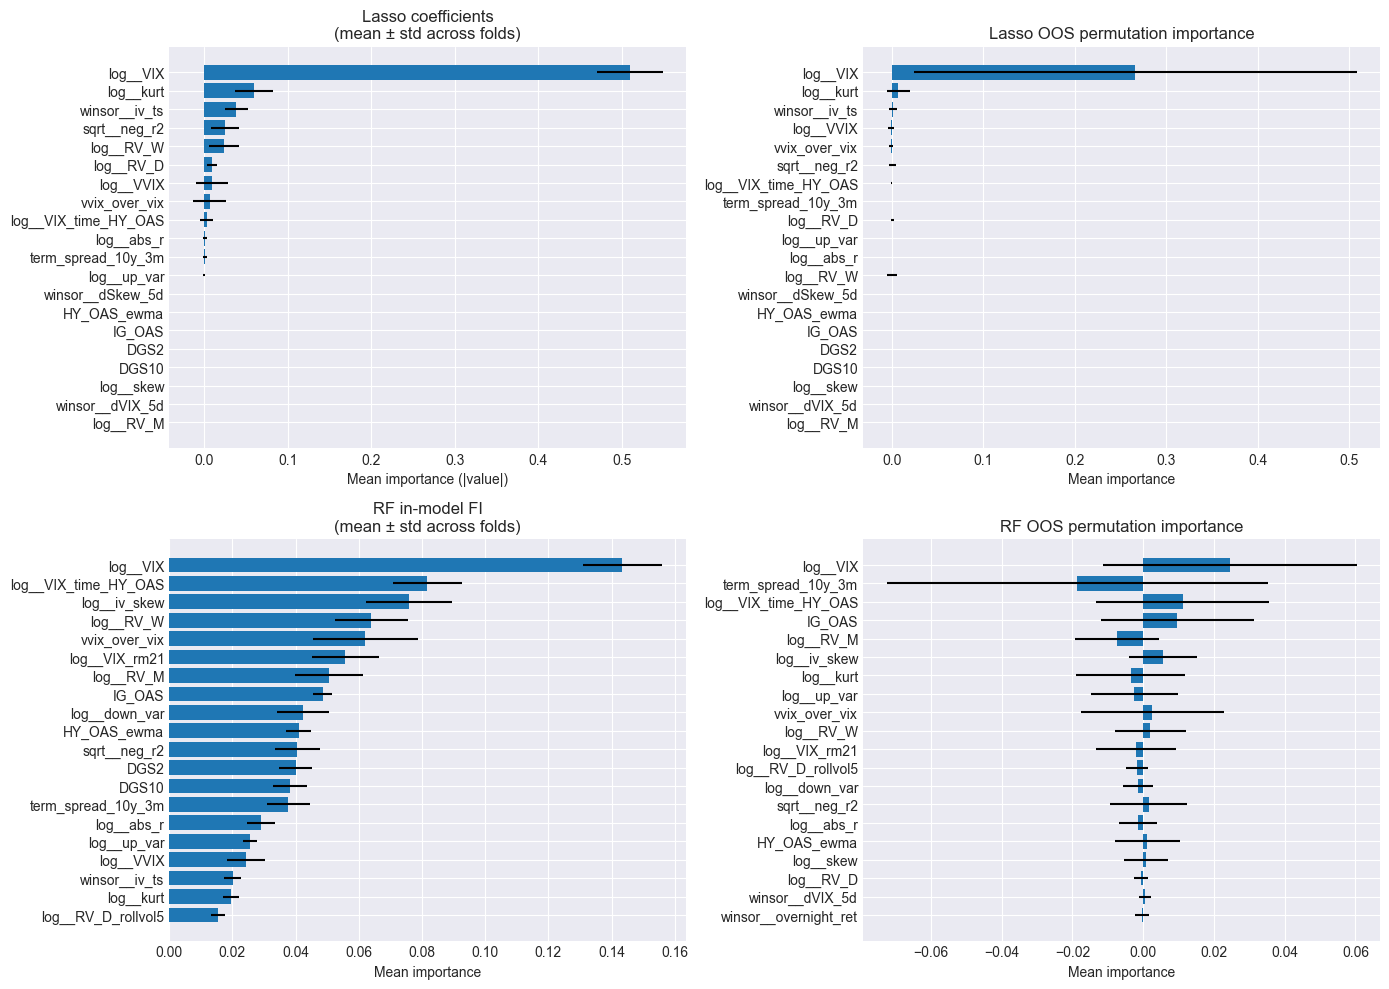

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Lasso coefficients
plot_mean_std_importance_ax(
    axes[0, 0],
    coefs,
    feature_names,
    title="Lasso coefficients\n(mean ± std across folds)",
    top_n=20,
    abs_values=True,
)

# 2) RF in-model FI (MDI)
plot_mean_std_importance_ax(
    axes[1, 0],
    rf_fi,
    feature_names,
    title="RF in-model FI\n(mean ± std across folds)",
    top_n=20,
    abs_values=False,
)

# 3) Lasso OOS permutation importance
plot_mean_std_importance_ax(
    axes[0, 1],
    pi_lasso,
    feature_names,
    title="Lasso OOS permutation importance",
    top_n=20,
    abs_values=False,
)

# 4) RF OOS permutation importance
plot_mean_std_importance_ax(
    axes[1, 1],
    pi_rf,
    feature_names,
    title="RF OOS permutation importance",
    top_n=20,
    abs_values=False,
)

plt.tight_layout()
plt.show()

## 5 Folds Neg MSE

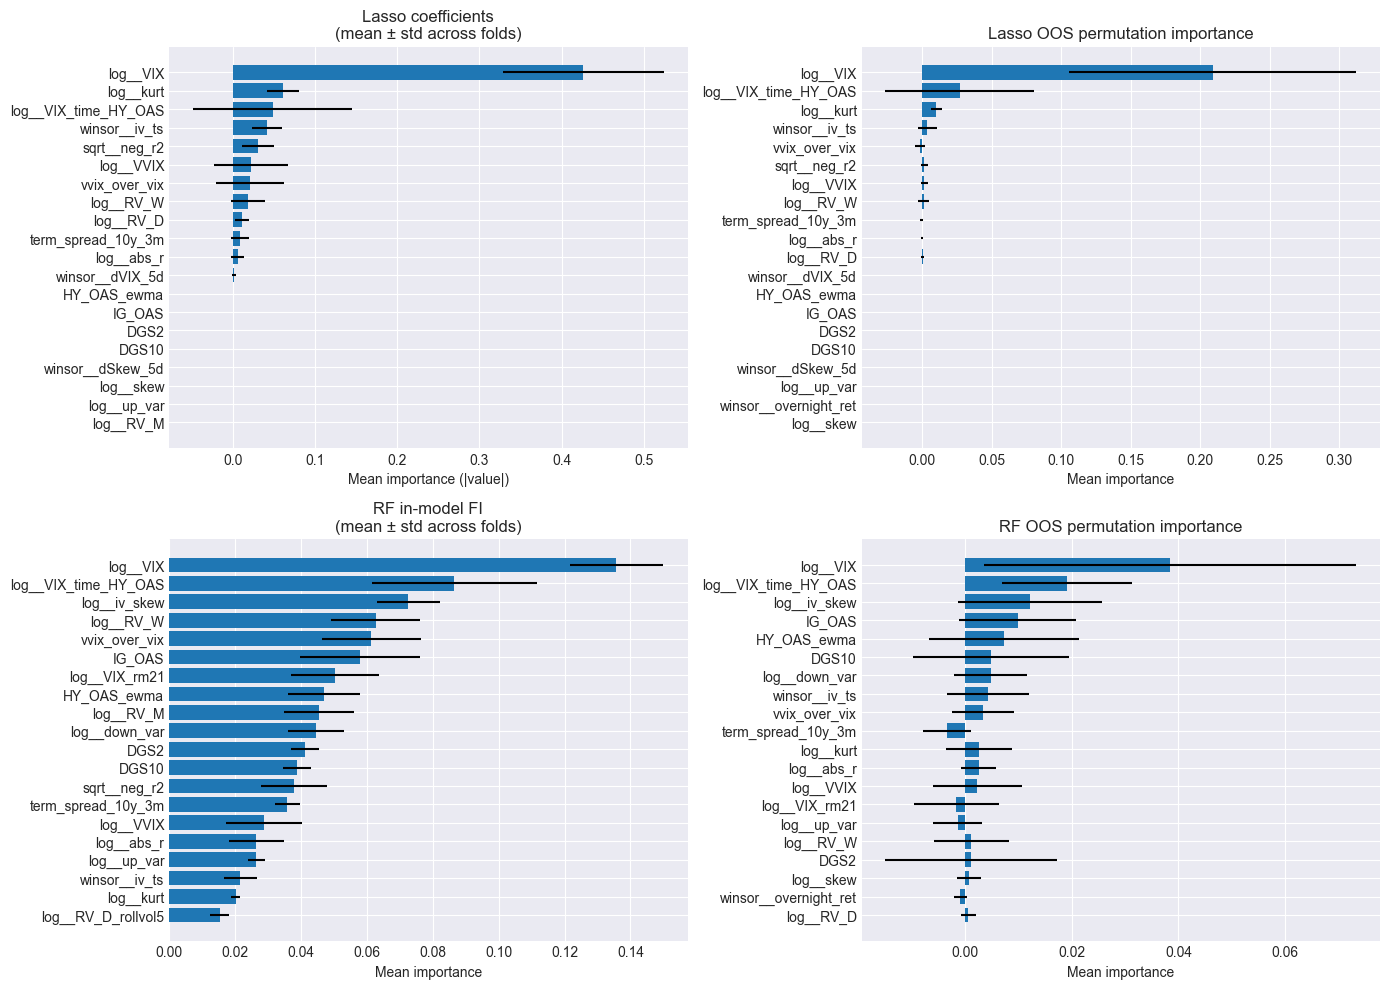

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Lasso coefficients
plot_mean_std_importance_ax(
    axes[0, 0],
    coefs,
    feature_names,
    title="Lasso coefficients\n(mean ± std across folds)",
    top_n=20,
    abs_values=True,
)

# 2) RF in-model FI (MDI)
plot_mean_std_importance_ax(
    axes[1, 0],
    rf_fi,
    feature_names,
    title="RF in-model FI\n(mean ± std across folds)",
    top_n=20,
    abs_values=False,
)

# 3) Lasso OOS permutation importance
plot_mean_std_importance_ax(
    axes[0, 1],
    pi_lasso,
    feature_names,
    title="Lasso OOS permutation importance",
    top_n=20,
    abs_values=False,
)

# 4) RF OOS permutation importance
plot_mean_std_importance_ax(
    axes[1, 1],
    pi_rf,
    feature_names,
    title="RF OOS permutation importance",
    top_n=20,
    abs_values=False,
)

plt.tight_layout()
plt.show()

## Single feature importance (SFI)
Use OLS on feature, collect predicitons on each CV fold, plot a bar of R2 OOS for each feature

In [1824]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


def run_sfi_linear(X, y, cv, model=None, metric="r2"):
    """
    Single-Feature Importance (SFI) for linear models.

    For each feature x_j:
      - Fit y ~ x_j in each CV train fold
      - Compute OOS R² on that fold's validation
    Returns a DataFrame with mean and std OOS R² per feature.
    """
    if model is None:
        model = LinearRegression()

    X = pd.DataFrame(X)
    y = pd.Series(y)
    features = X.columns.to_list()
    n_features = X.shape[1]
    n_folds = cv.get_n_splits(X, y)

    scores = np.zeros((n_folds, n_features))

    for fold, (tr, val) in enumerate(cv.split(X, y)):
        X_tr, y_tr = X.iloc[tr], y.iloc[tr]
        X_val, y_val = X.iloc[val], y.iloc[val]

        for j, col in enumerate(features):
            x_tr = X_tr[[col]]  # keep as DataFrame
            x_val = X_val[[col]]

            model.fit(x_tr, y_tr)
            y_pred = model.predict(x_val)

            if metric == "r2":
                score = r2_score(y_val, y_pred)
            elif metric == "mse":
                score =  mean_squared_error(y_val, y_pred)
            scores[fold, j] = score

    # aggregate per feature
    sfi_df = pd.DataFrame({
        "feature": features,
        f"mean_{metric}": scores.mean(axis=0),
        f"std_{metric}": scores.std(axis=0),
    }).sort_values(f"mean_{metric}", ascending=False if metric == "r2" else True)

    return sfi_df, scores

In [ ]:
sfi_df, scores = run_sfi_linear(X_clean, y_clean, cv=purged_cv)
sfi_df

feature   mean_r2    std_r2
8                log__VIX  0.094296  0.458382
12   log__VIX_time_HY_OAS -0.036310  0.588077
10          log__VIX_rm21 -0.153864  0.604459
2               log__RV_M -0.210842  0.625033
1               log__RV_W -0.241615  0.837368
24          vvix_over_vix -0.249641  0.643655
11           log__iv_skew -0.323693  1.120675
5             log__up_var -0.490353  0.853363
4           log__down_var -0.491323  1.081629
14           sqrt__neg_r2 -0.511751  1.459256
13     log__RV_D_rollvol5 -0.524555  1.233636
3              log__abs_r -0.528006  1.127728
0               log__RV_D -0.529282  1.215909
23            HY_OAS_ewma -0.650976  1.439473
22                 IG_OAS -0.671297  1.478303
9               log__VVIX -0.818647  2.269409
15          winsor__iv_ts -0.869091  1.932233
7               log__kurt -1.170567  2.135472
17        winsor__dVIX_5d -1.236403  2.531503
6               log__skew -1.250751  2.545263
18       winsor__dSkew_5d -1.264894  2.531224
16  winsor__overnight_ret -1.265433  2.566658
21     term_spread_10y_3m -1.427016  2.582552
20                   DGS2 -1.459888  2.343099
19                  DGS10 -1.484123  2.549098

In [1827]:
purged_cv = PurgedKFold(
    n_splits=5,    # ≈ 1-year val per fold
    purge_gap=21,   # your 21-day horizon
    embargo=0.01,   # small embargo 
)

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [1829]:
X_clean_lin = X_clean[["log__VIX", "log__kurt", "log__VIX_time_HY_OAS", "winsor__iv_ts", "log__RV_W", "log__RV_M", "sqrt__neg_r2"]]
X_clean_lin = X_clean[["log__VIX", "log__kurt", "log__VIX_time_HY_OAS", "log__RV_W", "log__RV_M"]]
X_clean_har = X_clean[["log__VIX", "log__RV_W", "log__RV_M"]]

In [1841]:
purged_cv2 = PurgedKFold(n_splits=40, purge_gap=21, embargo=0.01)

In [1758]:
y_pred

array([ 0.2987983 ,  0.55746041,  0.43374112, -0.14994538, -0.15619443,
        0.0999576 , -1.04914841,  0.33555786,  0.1303579 ,  0.34899754])

In [1839]:
y_pred_lin = cross_val_predict(LinearRegression(), X_clean_lin, y_clean, cv=purged_cv2, n_jobs=-1)
y_pred_lin = pd.Series(y_pred_lin, index=y_clean.index)
r2_score(y_clean, y_pred_lin)

0.5125566008017179

In [1842]:
y_pred_har = cross_val_predict(LinearRegression(), X_clean_har, y_clean, cv=purged_cv2, n_jobs=-1)
y_pred_har = pd.Series(y_pred_har, index=y_clean.index)
r2_score(y_clean, y_pred_har)

0.5081521279847692

In [1843]:
y_pred_rf = cross_val_predict(rf, X_clean, y_clean, cv=purged_cv2, n_jobs=-1)
y_pred_rf = pd.Series(y_pred_rf, index=y_clean.index)
r2_score(y_clean, y_pred_rf)

0.42578080140670016

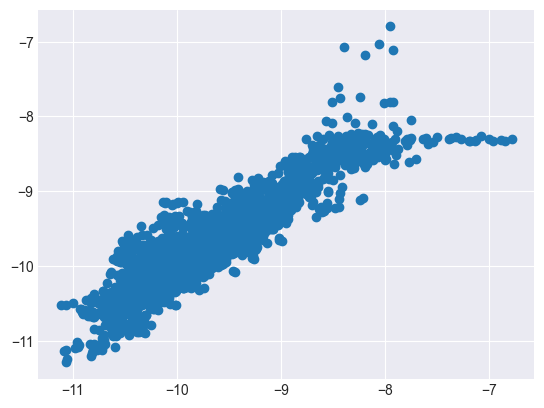

In [1844]:
plt.scatter(y_pred_lin, y_pred_rf)

In [1845]:
y_pred_lin.corr(y_pred_rf)

np.float64(0.9130188978432672)

In [1805]:
r2_score(y_clean, 0.5*y_pred_har + 0.3*y_pred_lin + 0.2*y_pred_rf)

0.5057289383052719

In [ ]:
y_pred = cross_val_predict(Lasso(), X_clean[["log__VIX", "log__RV_W", "log__RV_M", "log__kurt", "sqrt__neg_r2", "log__RV_D"]], y_clean, cv=purged_cv2, n_jobs=-1)
y_pred = pd.Series(y_pred, index=y_clean.index)

y_pred_rf = cross_val_predict(rf, X_clean, y_clean, cv=purged_cv2, n_jobs=-1)
y_pred_rf = pd.Series(y_pred_rf, index=y_clean.index)

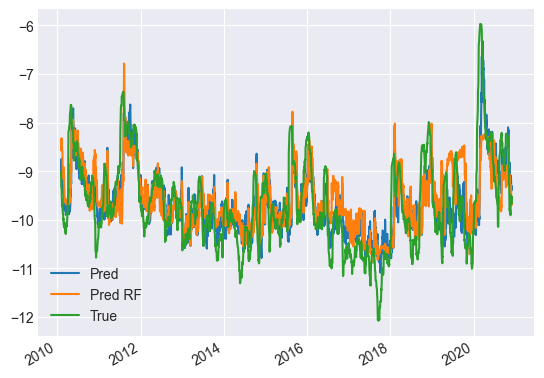

In [1676]:
y_pred.plot(label="Pred")
y_pred_rf.plot(label="Pred RF")
y_clean.plot(label="True")
plt.legend()

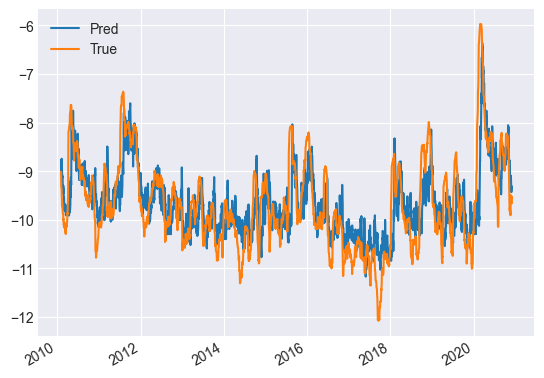

In [ ]:
y_pred.plot(label="Pred")
y_clean.plot(label="True")
plt.legend()

In [ ]:
sfi_df, sfi_scores = run_sfi_linear(X_clean, y_clean, purged_cv)
sfi_df  # top 20 features by OOS R²

feature   mean_R2    std_R2
8                log__VIX  0.294929  0.086601
12   log__VIX_time_HY_OAS  0.209846  0.087117
10          log__VIX_rm21  0.097467  0.093864
11           log__iv_skew  0.086281  0.207520
1               log__RV_W  0.081386  0.160824
2               log__RV_M  0.074438  0.107090
24          vvix_over_vix -0.020182  0.413011
4           log__down_var -0.100095  0.222663
13     log__RV_D_rollvol5 -0.102031  0.256368
14           sqrt__neg_r2 -0.104503  0.325389
0               log__RV_D -0.126413  0.248300
3              log__abs_r -0.129314  0.283740
5             log__up_var -0.130839  0.169674
23            HY_OAS_ewma -0.210844  0.260366
22                 IG_OAS -0.254681  0.322973
9               log__VVIX -0.327777  0.845932
15          winsor__iv_ts -0.355850  0.462645
7               log__kurt -0.572706  0.470223
6               log__skew -0.593231  0.523327
17        winsor__dVIX_5d -0.611232  0.595697
16  winsor__overnight_ret -0.628336  0.591622
18       winsor__dSkew_5d -0.632920  0.586226
20                   DGS2 -0.844091  0.569176
19                  DGS10 -0.869245  0.674761
21     term_spread_10y_3m -1.107146  0.708478

In [1634]:
y_pred

array([-9.0818382 , -8.75648373, -8.80005674, ..., -9.38547159,
       -9.36748864, -9.42771565], shape=(2792,))

## 6.3 Linear model relevance: Lasso Cross-Validation

Here we apply Embedded methods using Lasso and Eslatic Net (penalzies more too correlated features) to emphasize teh msot imporatnt feature that align with teh target.

# In-sample feature importance
Linear Models -> use weigths of given by Lasso

NON-Linear Models -> use MDI by creating own algo

# # Out-sample feature importance
Use both permutation imporatnce (MDI over QLIKE Loss or RSME)

# Out of sample wihtiout substituion effetcs
Using SIngle feature Imporatnce (fit eahc feature indivudally, evaulaute on OOS)



- Comapre the importanc eover volatiltiy regimes using Gaussian Mixture Models

<Axes: >

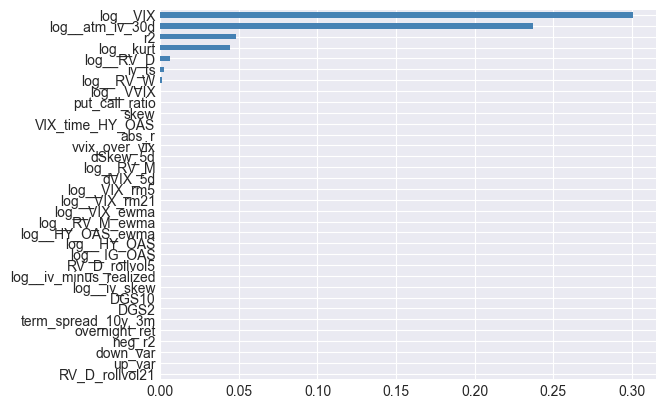

In [1230]:
tscv = TimeSeriesSplit(n_splits=5)

lasso_fs = LassoCV(
        alphas=np.logspace(-4, 0, 30),
        cv=tscv,
        max_iter=100000,
        n_jobs=-1
)

lasso_fs.fit(X_clean, y_clean)

lasso_imp = pd.Series(np.abs(lasso_fs.coef_), index=X_clean.columns)
lasso_imp = lasso_imp.sort_values(ascending=True)
lasso_imp.plot(kind="barh", color="steelblue")

In [ ]:
top_3_features_lin = lasso_imp.tail(3).index.tolist()
top_5_features_lin = lasso_imp.tail(5).index.tolist()
top_10_features_lin = lasso_imp.tail(10).index.tolist()

## 6.3 Tree model  relevance

Here we apply Embedded methods using Random forecast Feature imporatnce score to rank fetaures showing the ebst predciitve accuarcy with the target.

Here the idea is to dsicoevr in the reserach ste whihc features are used to explain the target (and not predict since it is in-sample). So they cna be used to remove compleytely useless features whihc is never selected by any tree to decerase impurity (can be quite confident it will have no predicitve accutacy OOS)

### Feature importance: Mean Decrease Impurity

<Axes: >

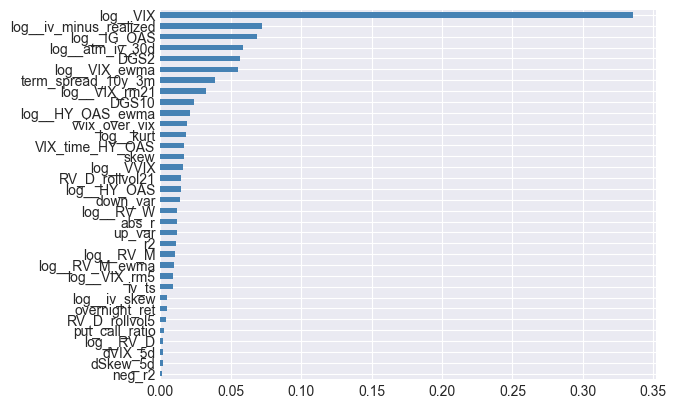

In [1229]:
rf_probe = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    random_state=0,
    n_jobs=-1,
    oob_score=False # Out-of-Bag validation performance
)

rf_probe.fit(X_clean, y_clean)

rf_imp = pd.Series(rf_probe.feature_importances_, index=X_proc.columns)
rf_imp = rf_imp.sort_values(ascending=True)

rf_imp.plot(kind="barh", color="steelblue")

### Permutation Imporatnce: Mean Decrease Accuracy

While MDI was used in-sample measuring the decerase impurity from the split of a given feature, permutaion imporatcne focuses is based on OOS data and consists in trainign a model on train data, and on a valdiaiton data randomly permutign rows of each column to see the average dcereas ein predicitve power. Here we use MDI just to identify and potentailly remove features with 0 imporatnce at all as they show 0 relationship wiht teh target, as here the MDA is used taking into accoutn the forecatsign power of eahc column.

Despite low importance features, since tree base models are robsut to mild unhelpful features we decide to not **pre-prunne** to keep all of them and will apply robsut cross validation latter to **post-pruning**. Indeed, dSkew, r2 and abs2, put-call-ratio may amtter less on average, but under tail regimes they amtetr a lot as they capture large vol spikes.

# **4. Model Classes**

FOrecasting is about fitting a model that minimized a cost function -> QLIKE or RMSE


## Linear Models:

### Econometrics models: HAR-RV, HAR-RV-IV, HAR-VIX
According to the literature and the observation

### Linear Regression models: OLS, Lasso, Ridge on the feature selected ones
Accoridng to statistical information

## Non-Linear models
In the EDA steps we observed some non-linearity (remember vvix_over_vix and otehr features had a nice polymnial relatinships)

### Ensemble tree based models
Capture non-linear and interactions effect between the features usign teh enriched dataset

### Neural Networks (LSTM)
Because of the long memory charasteristic we consider LSTM model that capture this
(something that RF might noty cpature jsut with rolling mean features)

# **4. Forecasting 21-D Realized Volatility**

FOrecasting is about fitting a model that minimized a cost function -> QLIKE or RMSE

---

### Why 21-Day Horizon?

- **Options market alignment:**  
  The 21-day horizon corresponds to ~1 month of trading days, matching the 30-day maturity of the most liquid index options.  
  This is also the tenor underlying the **VIX index**, which represents the market’s expectation of 30-day implied volatility.

- **Smoother target:**  
  Forward 21-day RV is much less noisy than daily RV.  
  Aggregating returns over a month produces a smoother series, closer to a rolling mean, which helps extract meaningful patterns.  
  This improves predictive power (higher $R^2$) and makes models more robust.

In [15]:
from abc import ABC, abstractmethod

class BaseRVForecaster(ABC):
    def __init__(self, H=21, name=None):
        self.H = H
        self.name = name or self.__class__.__name__

    @abstractmethod
    def fit(self, returns: pd.Series, rv: pd.Series, **kwargs):
        """Estimate parameters using a TRAIN window (no look-ahead)."""

    def warm_state(self, returns: pd.Series, rv: pd.Series):
        """Update internal state with observed data (no parameter re-fit)."""
        return self

    @abstractmethod
    def forecast(self, as_of_index: pd.DatetimeIndex) -> pd.Series:
        """Return ex-ante H-horizon RV forecast indexed by as_of_index."""


## **4.1 Log HAR-RV**

HAR-G -> residuals are heterosckedastic

## **4.1 GARCH family of models (GARCH(1, 1), EGARCH, GJR-GARCH)**

FIGARCH / HYGARCH — for long-memory volatility (useful for multi-day forecasts).

## **4.1 Machine Learning models (Bayesian RIDGE, Lasso, Random Forest, XGboost, LSTM)**

3. Long horizon (1-month ≈ 21D forward RV, or 3M)
	•	Predictability: much higher, smoother target, strong persistence and mean reversion.
	•	Economic relevance: directly matches option tenors (VIX = 30D, 3M IV).
	•	ML: more useful here because:
	•	Nonlinearities matter (IV term structure, skew effects, macro regimes).
	•	More predictors can be included (macro, credit spreads, realized correlations).
	•	HAR/GARCH become restrictive, while ML can flexibly combine many signals.
	•	Verdict: Best horizon for ML.

## **4.1 Ensemble Model**

Take the best model of each family and create an esnbmel fo predicitons. Either simple average prediciton, or weighted preidction 1/RMSE, bayesian modelling of the weights, kalman filters for dynamic parameters, markov-swithcing models in low vs high volaility regimes.
Once a model is chsoen for a given family keep it for the all testing, jsut update the weights dinamically and refit the mdoel every month or week. 
For HAR and GARCH family of models, can use AIC and QLIKE as well as LR tets for incremental parameters.

In [16]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from arch import arch_model
from sklearn.ensemble import GradientBoostingRegressor

class RVForecaster:
    def __init__(self, returns, rv):
        """
        Parameters
        ----------
        returns : pd.Series
            Daily log returns of the underlying.
        rv : pd.Series
            Realized volatility series (e.g. 21D rolling, annualized).
        """
        self.returns = returns.dropna()
        self.rv = rv.dropna()
    
    # === EWMA ===
    def ewma(self, lam=0.94):
        """RiskMetrics EWMA volatility forecast."""
        sigma2 = 0
        forecasts = []
        for r in self.returns:
            sigma2 = lam * sigma2 + (1 - lam) * r**2
            forecasts.append(np.sqrt(sigma2 * 252))
        return pd.Series(forecasts, index=self.returns.index, name="EWMA")
    
    # === HAR-RV ===
    def har(self, lags=(1,5,22)):
        """HAR-RV model using daily/weekly/monthly realized vol."""
        df = pd.DataFrame({"RV": self.rv})
        for lag in lags:
            df[f"lag{lag}"] = self.rv.shift(lag).rolling(lag).mean()
        df = df.dropna()
        X = sm.add_constant(df[[f"lag{l}" for l in lags]])
        model = OLS(df["RV"], X).fit()
        forecast = model.predict(X)
        return forecast.rename("HAR-RV")
    
    # === GARCH(1,1) ===
    def garch(self):
        """GARCH(1,1) forecast."""
        model = arch_model(self.returns*100, vol="GARCH", p=1, q=1, dist="normal")
        res = model.fit(disp="off")
        forecast = res.forecast(horizon=1).variance.iloc[:,0]**0.5 / 100
        forecast = forecast.rename("GARCH(1,1)")
        return forecast
    
    # === ML (GBM by default) ===
    def ml(self, features, model=None):
        """Forecast RV using ML (GradientBoosting by default)."""
        if model is None:
            model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        X = features.shift(1).dropna()
        y = self.rv.loc[X.index]
        model.fit(X, y)
        forecast = pd.Series(model.predict(X), index=X.index, name="ML-RV")
        return forecast

ModuleNotFoundError: No module named 'arch'